Imports

In [239]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import collections
%matplotlib inline

import sklearn as sk
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from time import time
from scipy import ndimage
from sklearn import manifold

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import operator
import pickle as pk
from sklearn.cluster import AgglomerativeClustering

from itertools import chain
import numpy.linalg as LA
from scipy.spatial.distance import pdist

In [176]:
original_dataset_digits = pd.read_csv('DatasetChampionIndices.csv')

In [295]:
with open('ChampionsAllInfo.pkl', 'rb') as inp:
    champions = pk.load(inp)
    
# champion stats normalization and preprocessing
# Standard Normalization (x-mean(x) / std(x))
STAT = True
champions_stats = []
for i in range(len(champions)):
    if STAT:
        stat = champions[i]['stats']
        champions_stats.append([stat['hp'], stat['attackdamage'], stat['armor'], stat['spellblock'], stat['movespeed'], stat['attackrange'], stat['hpregen']])
    else:
        info = champions[i]['info']
        champions_stats.append([info['attack'], info['defense'], info['difficulty'], info['magic']])
min_max_scaler = preprocessing.StandardScaler()
champions_stats_normalized = min_max_scaler.fit_transform(champions_stats)

making the dataset in 0-1 format

In [178]:
original_dataset = []
for sample in original_dataset_digits.as_matrix()[:,:-1]:
    if np.any(sample > 131) or np.any(sample < 0):
        continue
    w = np.zeros(132)
    for s in sample[:5]:
        w[int(s)] = 1
    l = np.zeros(132)
    for s in sample[5:]:
        l[int(s)] = 1
    original_dataset.append(np.hstack((w,l)))

In [179]:
dataset = pd.DataFrame(original_dataset)
dataset = dataset.sample(n=10000, replace=False)

In [180]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,254,255,256,257,258,259,260,261,262,263
14118,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6825,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16452,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15083,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Champion counts chosen by winners and losers

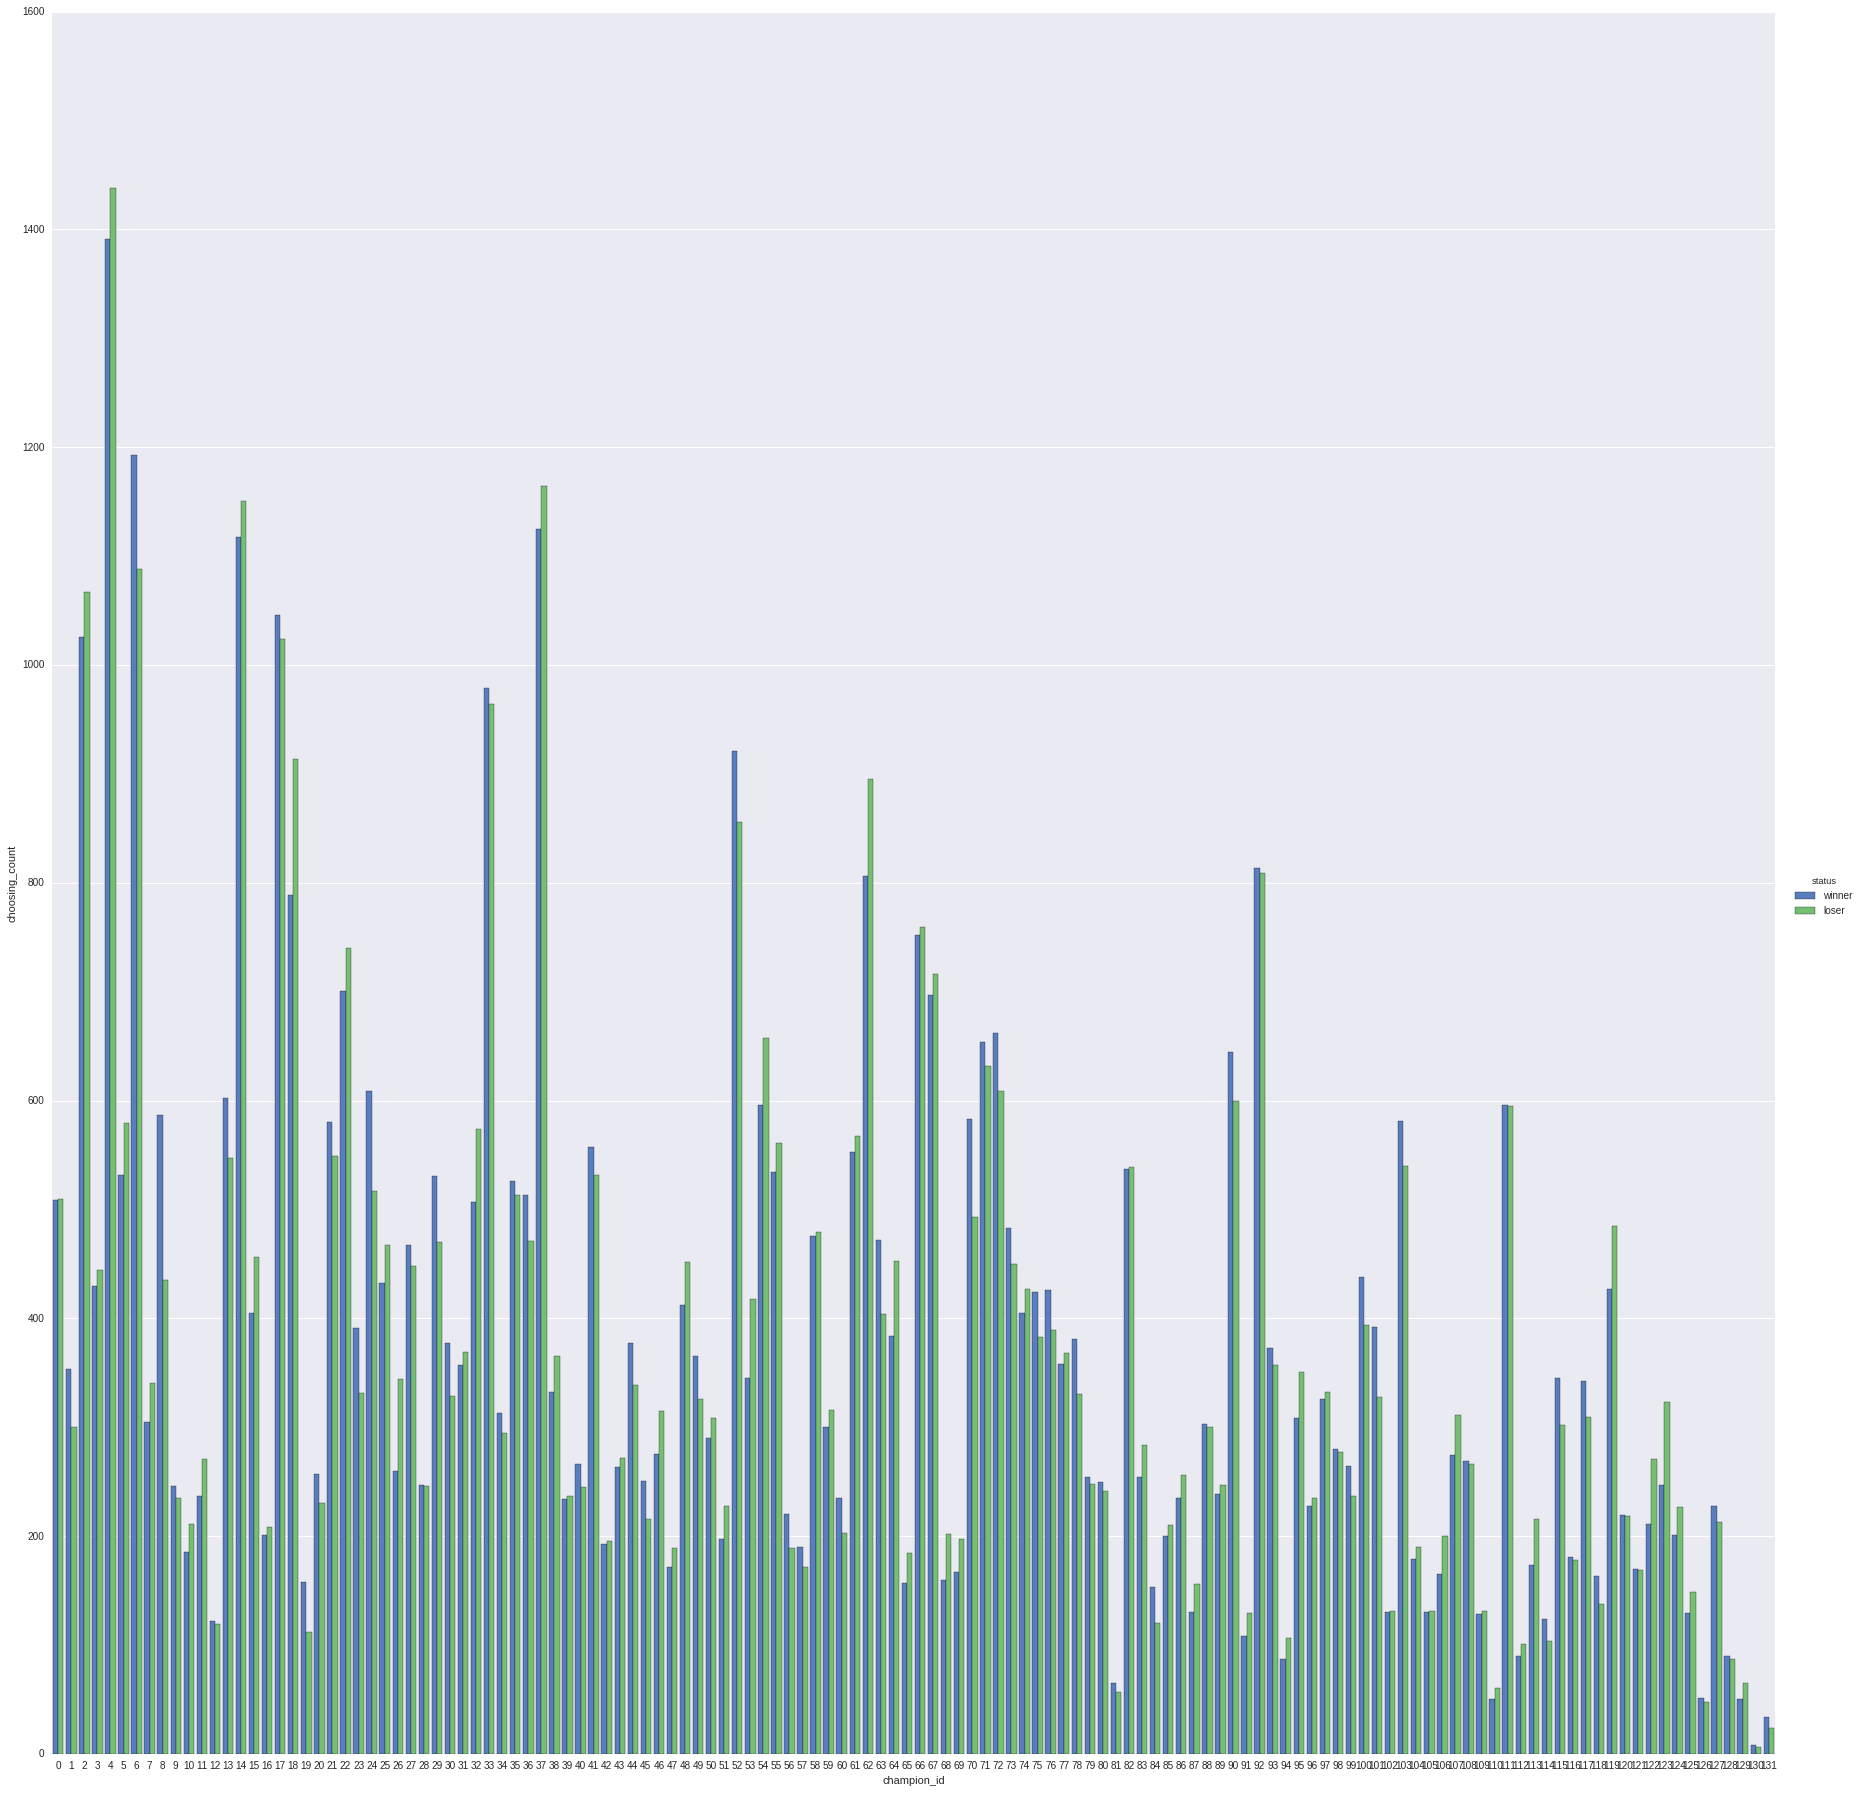

In [181]:
all_winners = dataset.ix[:,:131].as_matrix()
all_losers = dataset.ix[:,132:].as_matrix()
all_counts = []
for i in range(132):
    all_counts.append([i, len(np.where(all_winners[:,i]==1)[0]), 'winner'])
for i in range(132):
    all_counts.append([i, len(np.where(all_losers[:,i]==1)[0]), 'loser'])
dt = pd.DataFrame(all_counts, columns=['champion_id', 'choosing_count', 'status'])

g = sns.factorplot(x="champion_id", y="choosing_count", hue="status", data=dt,
                   size=25, kind="bar", palette="muted")

Adding label and swapping 50% of winners and losers
;Thus:

label 0 == winner + loser

label 1 == loser + winner

In [182]:
dataset['label'] = np.zeros([len(dataset),1])
dt = dataset.as_matrix()
idx = np.random.choice(len(dt), int(len(dt)/2), replace=False)
tf = math.floor(dt.shape[1]/2)
tmp = dt[idx,tf:2*tf]
dt[idx,tf:2*tf] = dt[idx,:tf]
dt[idx,:tf] = tmp
dt[idx,-1] = 1
dataset = pd.DataFrame(data=dt, columns=dataset.columns)

In [183]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,255,256,257,258,259,260,261,262,263,label
14118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16452,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15083,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
dataset.to_csv('BinaryChampionDataset.csv')

In [497]:
# %load plot_data.py
# Omid55
def plot_data(data, has_label=True):
	import numpy as np
	from sklearn.manifold import TSNE
	from sklearn.decomposition import PCA

	if not has_label:
		data = data.copy()
		data['label'] = np.zeros([len(data),1])

	LIMIT = 4000
	if data.shape[0] > LIMIT:
		dt = data.sample(n=LIMIT, replace=False)
		X = dt.ix[:,:-1]
		labels = dt.ix[:,-1]
	else:
		X = data.ix[:,:-1]
		labels = data.ix[:,-1]

	tsne_model = TSNE(n_components=2, random_state=0)
	np.set_printoptions(suppress=True)
	points1 = tsne_model.fit_transform(X)
	df1 = pd.DataFrame(data=np.column_stack([points1,labels]), columns=["x","y","class"])
	sns.lmplot("x", "y", data=df1, hue='class', fit_reg=False, palette=sns.color_palette('colorblind'))
	sns.plt.title('TNSE')

	pca = PCA(n_components=2)
	pca.fit(X)
	points2 = pca.transform(X)
	df2 = pd.DataFrame(data=np.column_stack([points2,labels]), columns=["x","y","class"])
	sns.lmplot("x", "y", data=df2, hue='class', fit_reg=False, palette=sns.color_palette('colorblind'))
	sns.plt.title('PCA')


In [553]:
# %load print_class_ratio.py
# Omid55
def print_class_ratio(data):
	assert 'label' in data, 'The dataset does not have required label column.'
	if type(data) is pd.core.frame.DataFrame:
		labels = set(data['label'])
	print('Data has', len(data), 'samples,')
	for l in labels:
		print(int(l),': ', 100 * len(np.where(data['label'] == l)[0]) / len(data), '%')

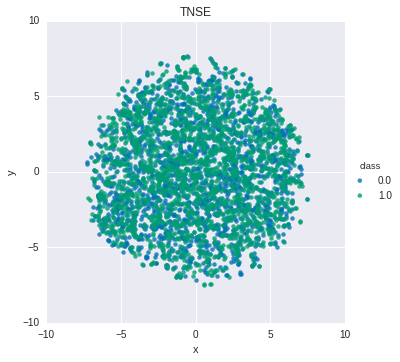

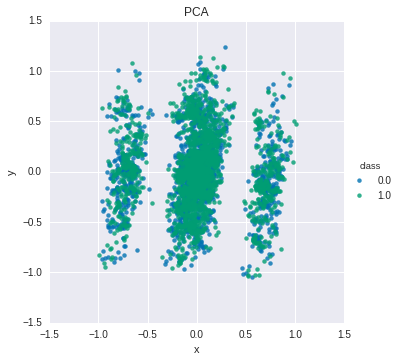

In [11]:
plot_data(dataset)

Now dataset is ready for classification

In [564]:
# %load do_classification.py
#Omid55
def do_classification(dataset):
    
    # import print_class_ratio.py

    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import cross_validation
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn import svm
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
    from sklearn.linear_model import SGDClassifier
    from sklearn.dummy import DummyClassifier

    if type(dataset) is pd.core.frame.DataFrame:
        dataset = dataset.as_matrix()

    #clf = MLPClassifier(algorithm='l-bfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    models = [(SGDClassifier(), 'Stochastic Gradient Descent Classifier'),
        (LogisticRegression(), 'Logistic Regression'),
        (GaussianNB(), 'Naive Bayes'),
        (svm.LinearSVC(C=1.0, verbose=False), 'Linear SVM'),
        (svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False), 'SVM with RBF kernel'),
        (RandomForestClassifier(n_estimators=100), 'Random Forest'),
        (KNeighborsClassifier(n_neighbors=8), 'KNN'),
        (DecisionTreeClassifier(max_depth=5), 'Decision Tree'),
        (AdaBoostClassifier(), 'AdaBoost'),
        (LinearDiscriminantAnalysis(), 'Linear Discriminant Analysis'),
        (QuadraticDiscriminantAnalysis(), 'Quadratic Discriminant Analysis')]
    
    #print(print_class_ratio(dataset))
    #print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
    # applying the models
    n_folds = 10
    k_fold = cross_validation.KFold(n=len(dataset), n_folds=n_folds, shuffle=False, random_state=None)
    accuracy = {}
    train_accuracy = {}
    for train_index, test_index in k_fold:
        X_train = dataset[train_index,:-1]
        y_train = dataset[train_index,-1]
        X_test = dataset[test_index,:-1]
        y_test = dataset[test_index,-1]

        for clf, name in models:
            clf.fit(X_train, y_train)

            # test data accuracy
            y_pred = clf.predict(X_test)
            accuracy_percent = 100 * sk.metrics.accuracy_score(y_test, y_pred) / n_folds
            if name not in accuracy:
                accuracy[name] = accuracy_percent
            else:
                accuracy[name] += accuracy_percent

            # train data accuracy
            y_train_pred = clf.predict(X_train)
            train_accuracy_percent = 100 * sk.metrics.accuracy_score(y_train, y_train_pred) / n_folds
            if name not in train_accuracy:
                train_accuracy[name] = train_accuracy_percent
            else:
                train_accuracy[name] += train_accuracy_percent
        result = []
        for key in accuracy.keys():
            result.append([key, round(accuracy[key],2), round(train_accuracy[key],2)])
        result_accuracy_df = pd.DataFrame(data=result, columns=['classifier', 'test acc', 'train acc'])
    return result_accuracy_df


Hierarchical clustering

In [322]:
# %load visualize_hierarchical_clusters.py
# Omid55
def visualize_hierarchical_clusters(data, NUMBER_OF_CLUSTERS, metric='cosine'):
    from sklearn.cluster import AgglomerativeClustering

    X = np.asmatrix(data.ix[:,:-1])
    y = np.asanyarray(data['label'])
    
    #----------------------------------------------------------------------
    # Visualize the clustering
    def plot_clustering(X_red, X, labels, title=None):
        x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
        X_red = (X_red - x_min) / (x_max - x_min)

        plt.figure(figsize=(6, 4))
        for i in range(X_red.shape[0]):
            plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                     color=plt.cm.spectral(labels[i] / 10.),
                     fontdict={'weight': 'bold', 'size': 9})

        plt.xticks([])
        plt.yticks([])
        if title is not None:
            plt.title(title, size=17)
        plt.axis('off')
        plt.tight_layout()

    #----------------------------------------------------------------------
    # 2D embedding of the digits dataset
    print("Computing embedding")
    X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
    print("Done.")

    if metric == 'euclidean':
        linkages = ['ward', 'average', 'complete']
    else:
        linkages = ['average', 'complete']

    for linkage in linkages:
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS)
        t0 = time()
        clustering.fit(X_red)
        print("%s : %.2fs" % (linkage, time() - t0))
        plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)

    plt.show()

In [16]:
dataset_sampled = dataset.sample(n=4000, replace=False)

# Clustering Visualization

Computing embedding
Done.
average : 16.47s
complete : 16.32s


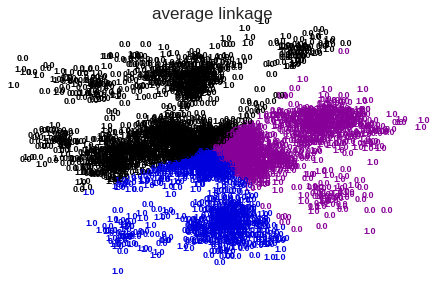

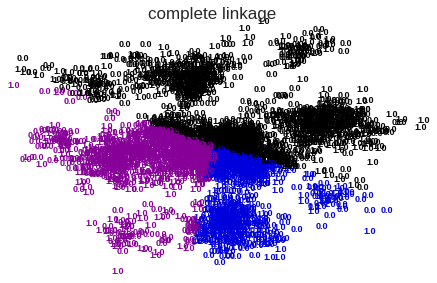

In [320]:
visualize_hierarchical_clusters(dataset_sampled, 3)

Computing embedding
Done.
average : 17.33s
complete : 16.97s


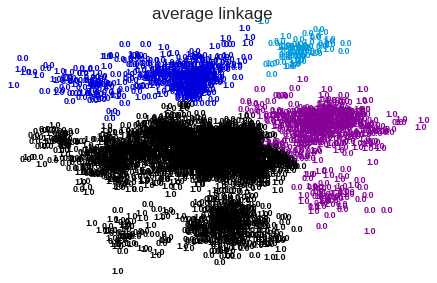

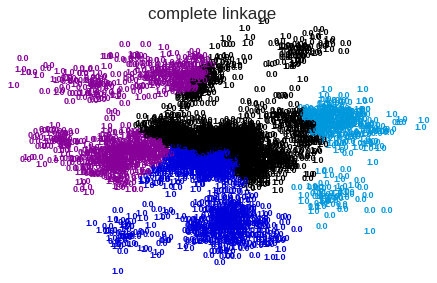

In [323]:
visualize_hierarchical_clusters(dataset_sampled, 4)

Computing embedding
Done.
average : 17.36s
complete : 16.92s


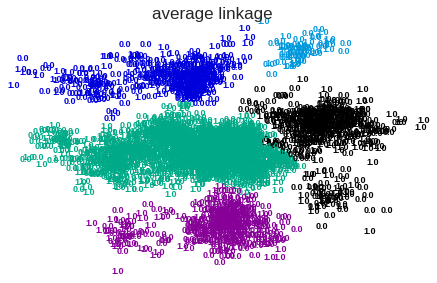

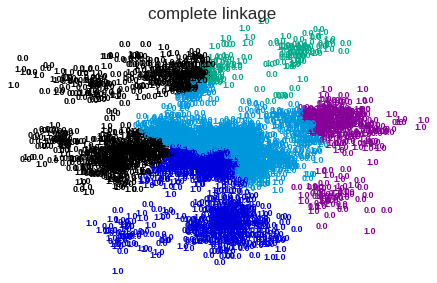

In [324]:
visualize_hierarchical_clusters(dataset_sampled, 5)

Computing embedding
Done.
average : 17.31s
complete : 16.92s


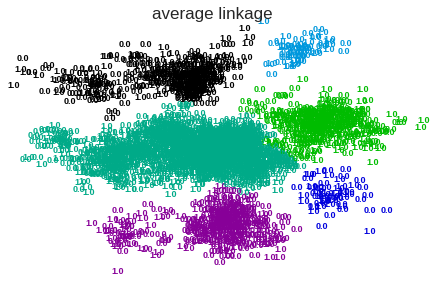

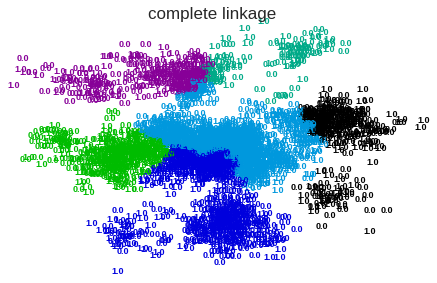

In [325]:
visualize_hierarchical_clusters(dataset_sampled, 6)

Computing embedding
Done.
average : 18.73s
complete : 18.15s


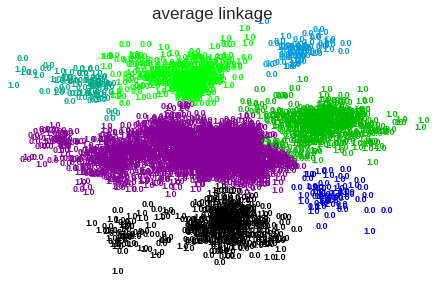

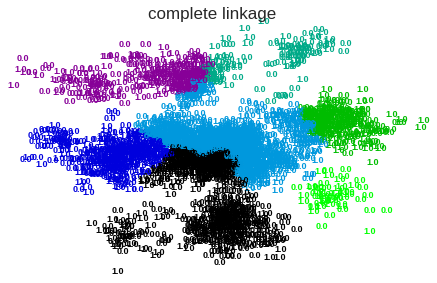

In [326]:
visualize_hierarchical_clusters(dataset_sampled, 7)

Computing embedding
Done.
average : 17.45s
complete : 16.92s


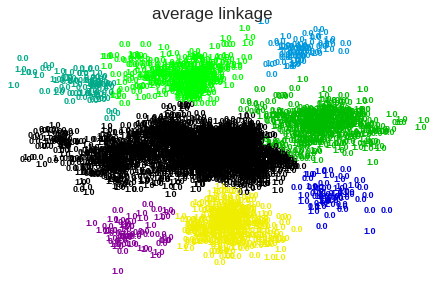

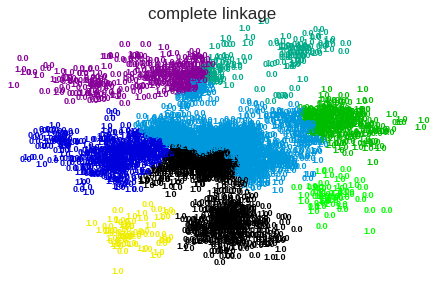

In [327]:
visualize_hierarchical_clusters(dataset_sampled, 8)

Computing embedding
Done.
average : 17.41s
complete : 16.91s


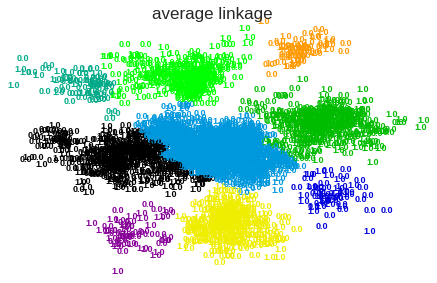

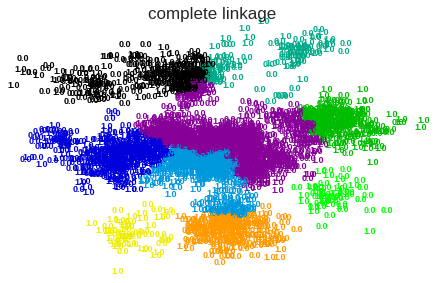

In [328]:
visualize_hierarchical_clusters(dataset_sampled, 9)

Classification on whole dataset and just with 9 clusters

In [329]:
import warnings
warnings.filterwarnings('ignore')

print('Classification on whole dataset:')
acc = do_classification(dataset_sampled)

Classification on whole dataset:
KNN : 49.5
Linear SVM : 50.75
Stochastic Gradient Descent Classifier : 50.55
Random Forest : 50.32
Linear Discriminant Analysis : 50.75
Naive Bayes : 50.97
Decision Tree : 50.35
Quadratic Discriminant Analysis : 50.45
Logistic Regression : 50.88
AdaBoost : 49.65
SVM with RBF kernel : 49.78


In [340]:
NUMBER_OF_CLUSTERS = 9
just_print_the_best = True

X = np.asmatrix(dataset_sampled.ix[:,:-1])
y = np.asanyarray(dataset_sampled['label'])
for linkage in ('average', 'complete'):
    accuracies = collections.defaultdict(lambda: 0)
    print('Linkage is', linkage, '=>\n\n')
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS, affinity='cosine')
    clustering.fit(X)
    for cluster_index in range(NUMBER_OF_CLUSTERS):
        idx = np.where(clustering.labels_==cluster_index)[0]
        print('Length of this cluster is:', len(idx),'\n')
        if len(idx) > 20:
            if just_print_the_best:
                accuracy = do_classification(np.column_stack((X[idx,:], y[idx])), verbose=False)
                print(max(accuracy.items(), key=operator.itemgetter(1)))
            else:
                accuracy = do_classification(np.column_stack((X[idx,:], y[idx])), verbose=True)
            print('\n----------------------------------------------\n')
    print('\n\n\n================================================')

Linkage is average =>


Length of this cluster is: 2936 

('Decision Tree', 51.635671333379761)

----------------------------------------------

Length of this cluster is: 551 

('SVM with RBF kernel', 53.172077922077918)

----------------------------------------------

Length of this cluster is: 209 

('Naive Bayes', 57.857142857142861)

----------------------------------------------

Length of this cluster is: 180 

('AdaBoost', 63.333333333333336)

----------------------------------------------

Length of this cluster is: 48 

('Decision Tree', 65.0)

----------------------------------------------

Length of this cluster is: 11 

Length of this cluster is: 19 

Length of this cluster is: 13 

Length of this cluster is: 33 

('Stochastic Gradient Descent Classifier', 59.166666666666664)

----------------------------------------------




Linkage is complete =>


Length of this cluster is: 3772 

('Linear Discriminant Analysis', 51.138478379857688)

-----------------------------------

In [27]:
def print_one_cluster_champions(clustering, cluster_label):
    idx = np.where(clustering.labels_==cluster_label)[0]
    print('Length of this cluster is:', len(idx))
    cluster8 = np.column_stack((X[idx,:], y[idx]))

    winners = np.vstack((cluster8[np.where(cluster8[:,-1] == 1)[0],:132], cluster8[np.where(cluster8[:,-1] == 0)[0],132:-1]))
    losers = np.vstack((cluster8[np.where(cluster8[:,-1] == 1)[0],132:-1], cluster8[np.where(cluster8[:,-1] == 0)[0],:132]))

    counts = []
    for i in range(132):
        counts.append([i, len(np.where(winners[:,i]==1)[0]), 'winner'])
    for i in range(132):
        counts.append([i, len(np.where(losers[:,i]==1)[0]), 'loser'])
    dt = pd.DataFrame(counts, columns=['champion_id', 'choosing_count', 'status'])
    g = sns.factorplot(x="champion_id", y="choosing_count", hue="status", data=dt,
                       size=25, kind="bar", palette="muted")
    g.fig.show()

In [53]:
clustering = AgglomerativeClustering(linkage='average', n_clusters=NUMBER_OF_CLUSTERS)
clustering.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=9, n_components=None,
            pooling_func=<function mean at 0x7fd72c0f98c8>)

Length of this cluster is: 1274
Length of this cluster is: 168
Length of this cluster is: 1307
Length of this cluster is: 584
Length of this cluster is: 33
Length of this cluster is: 19
Length of this cluster is: 543
Length of this cluster is: 18
Length of this cluster is: 54


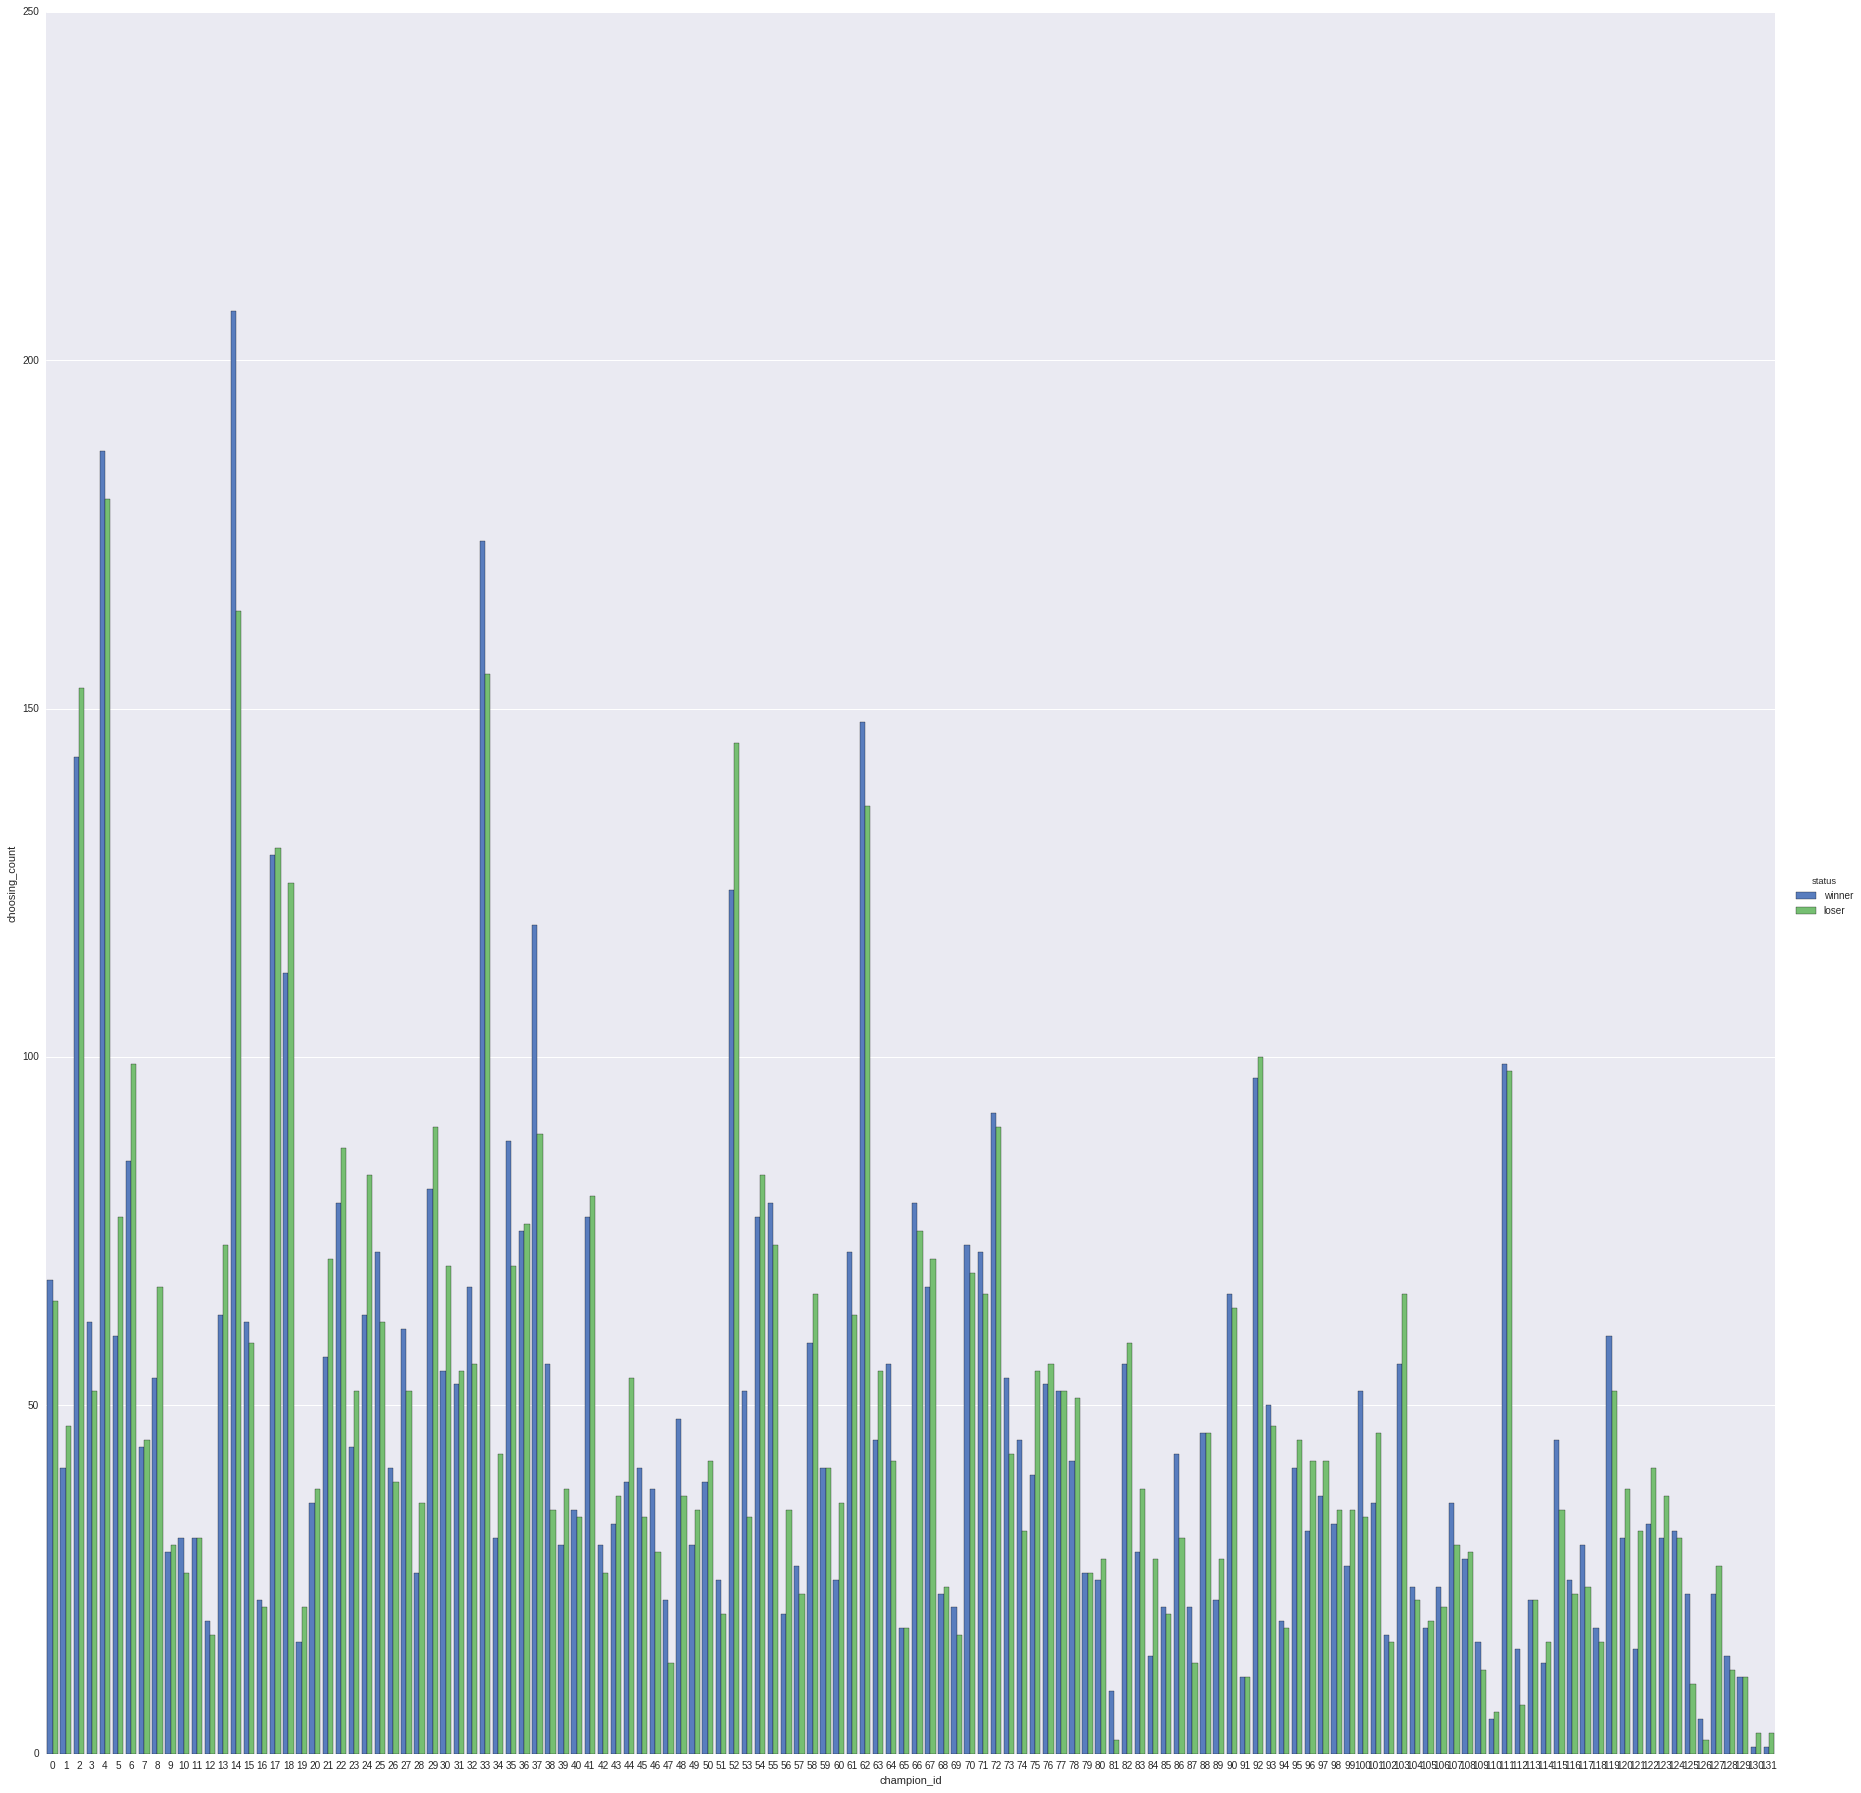

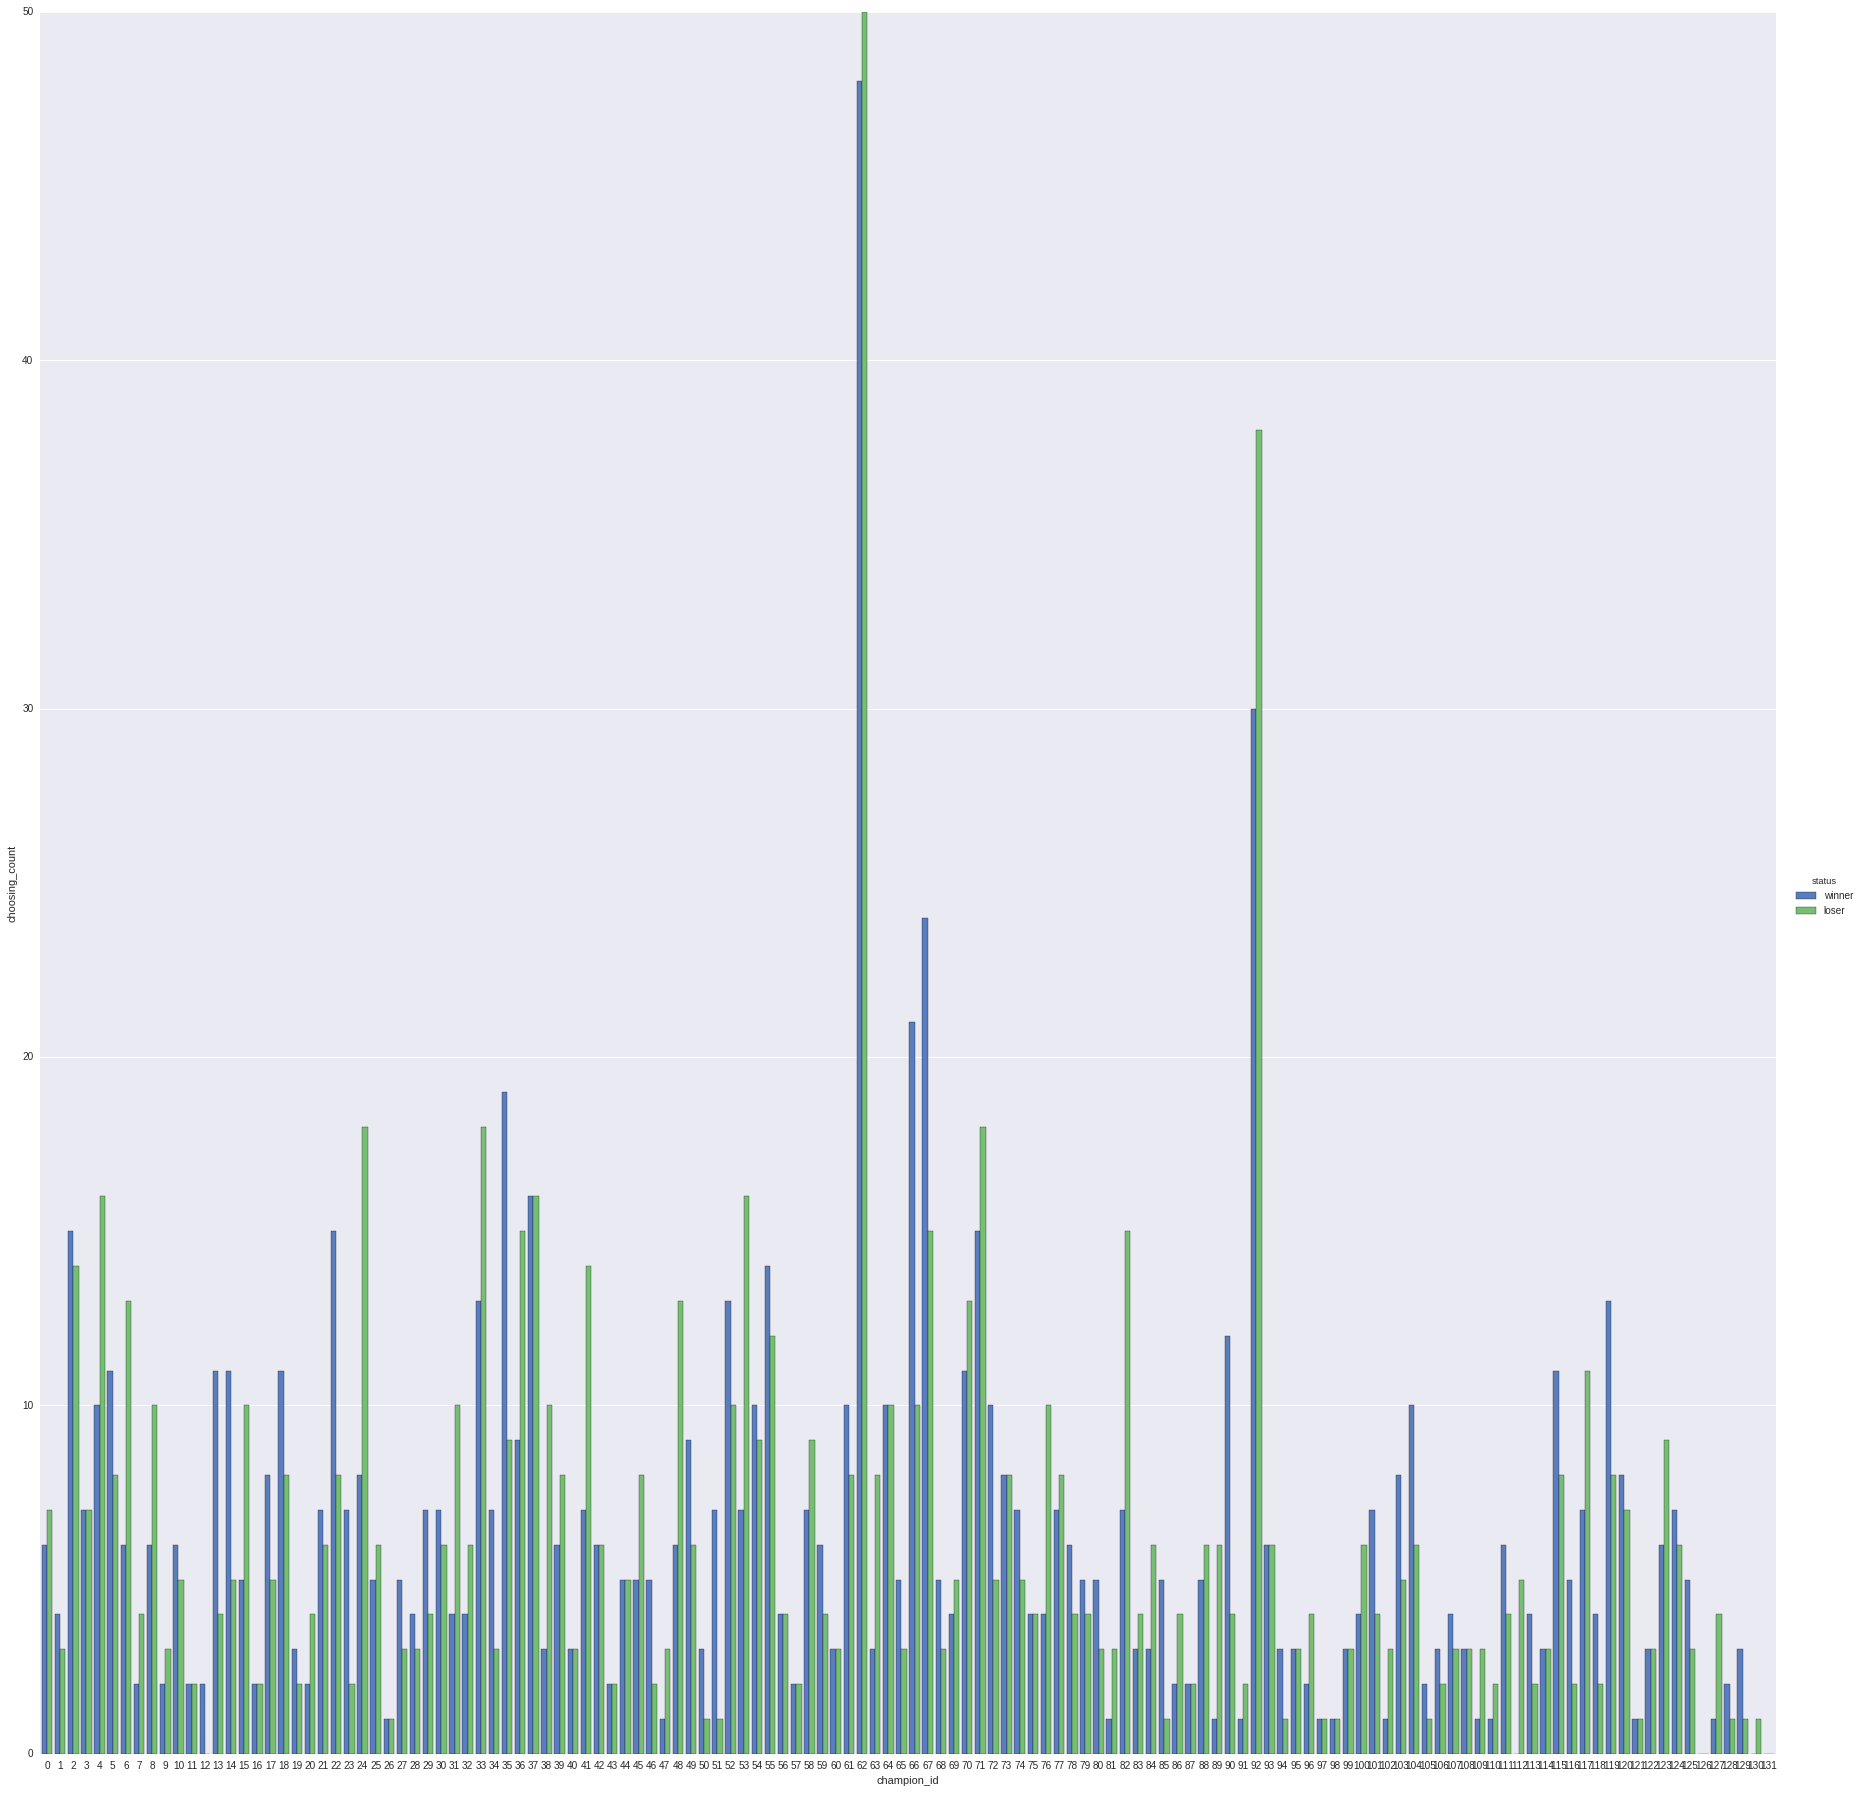

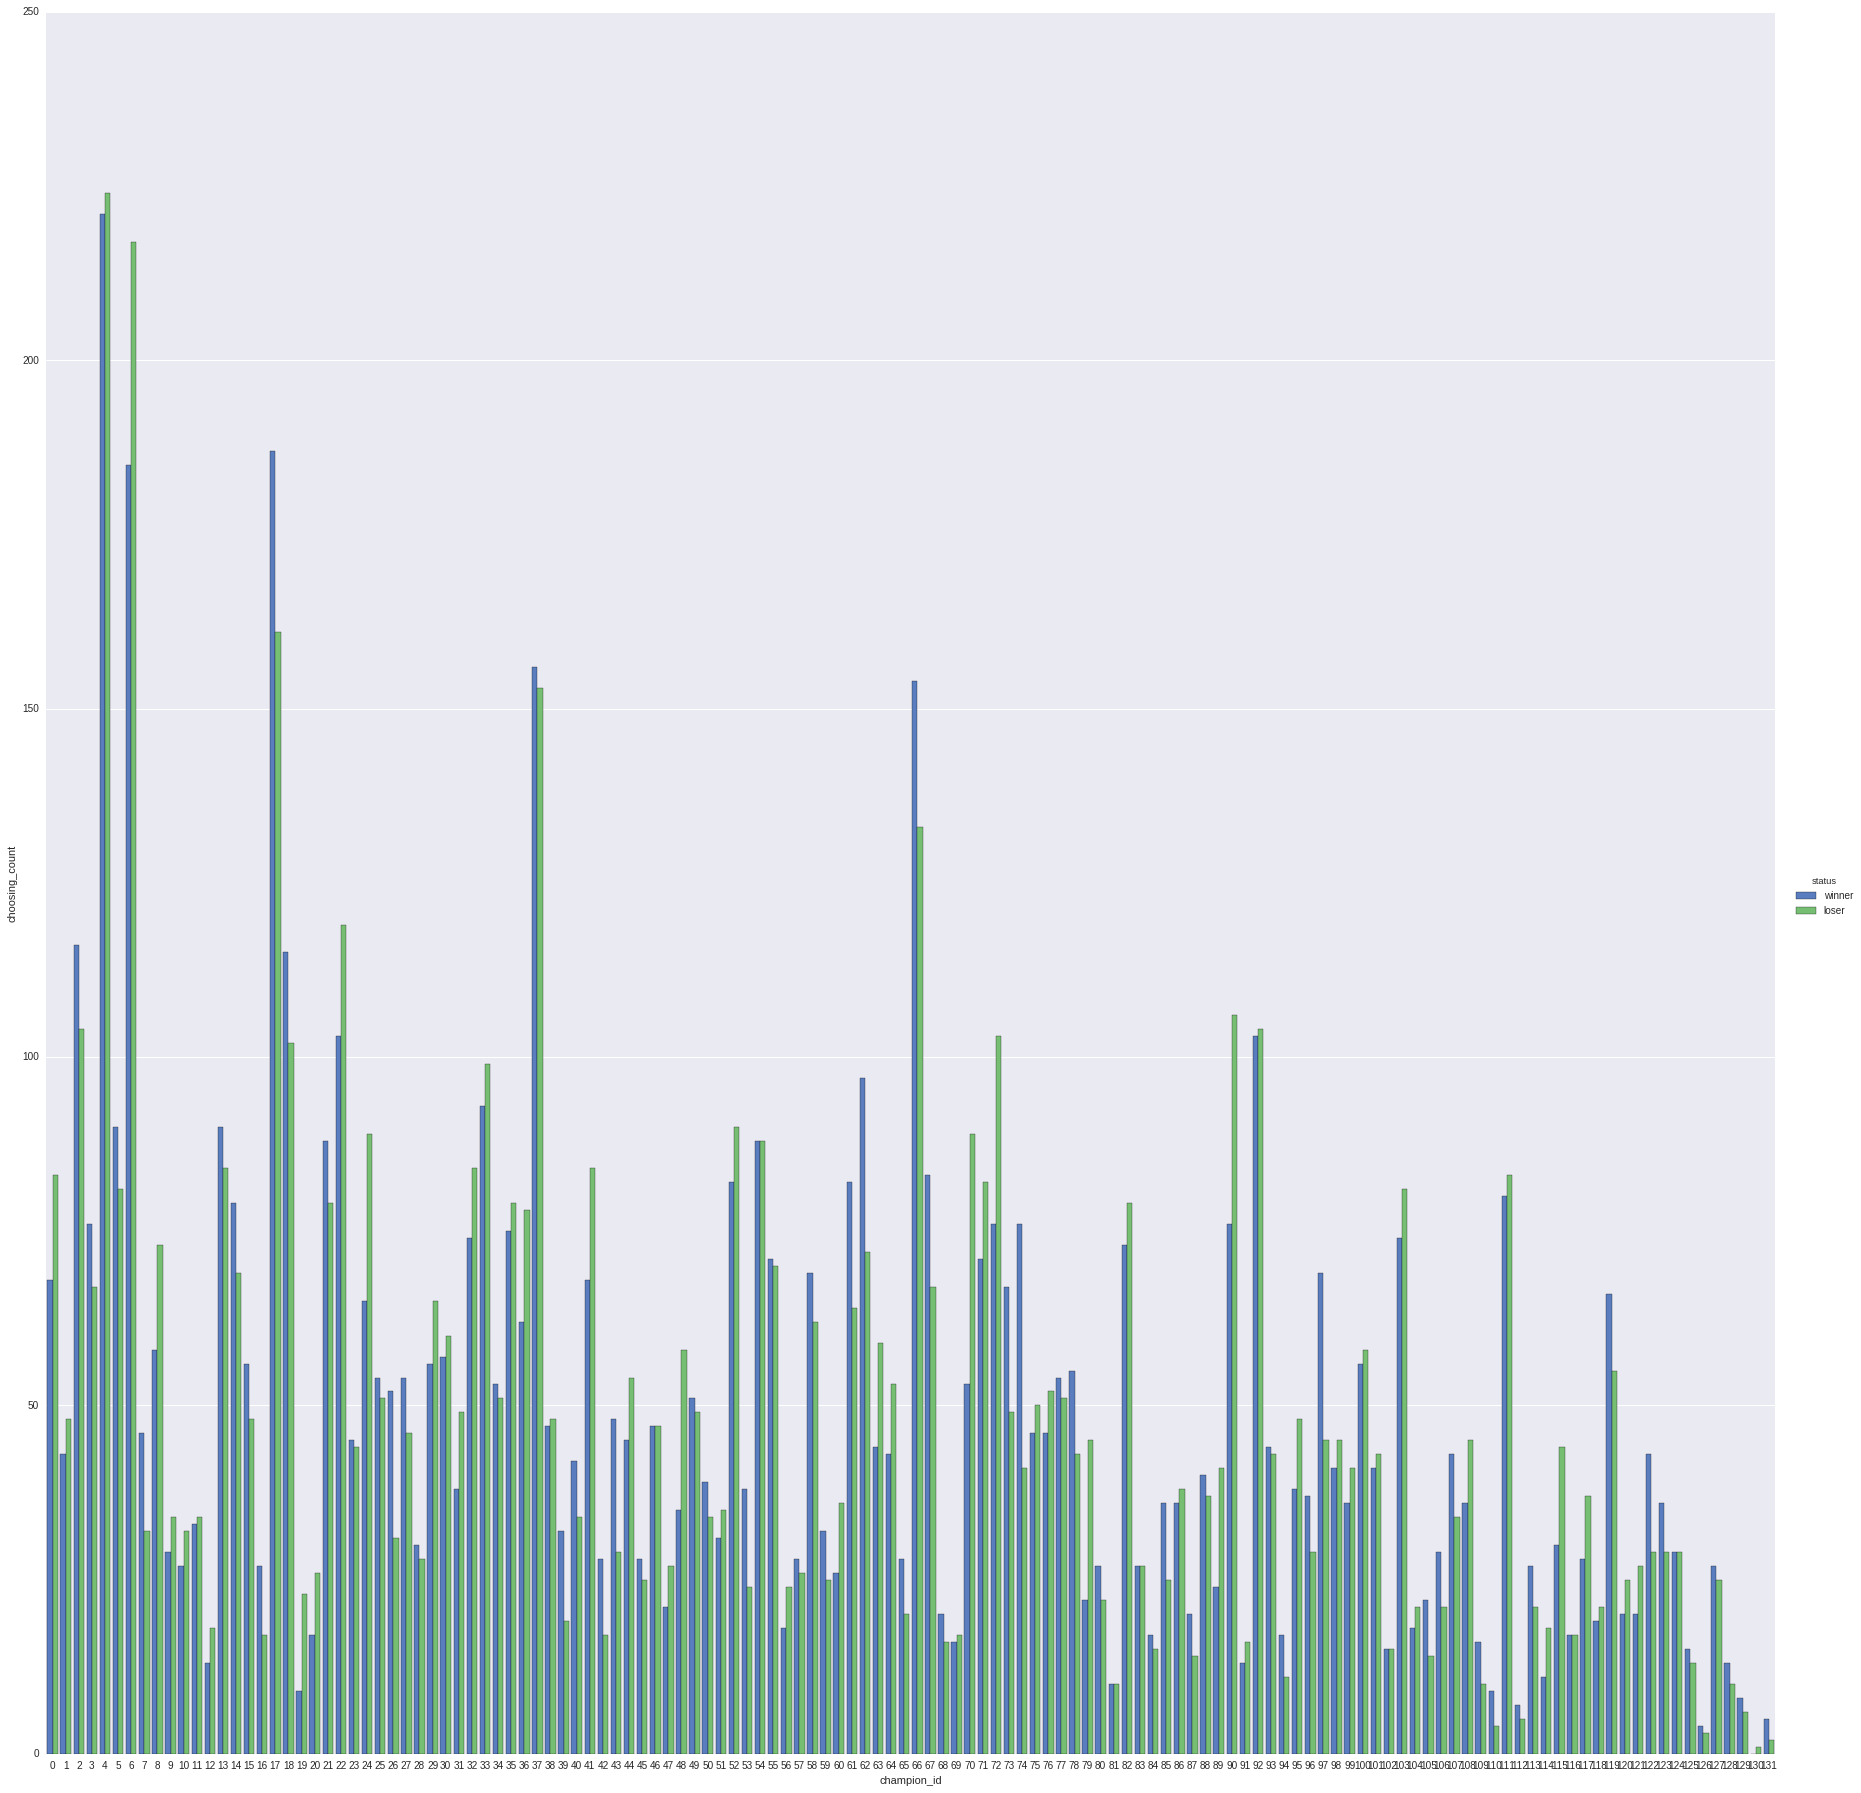

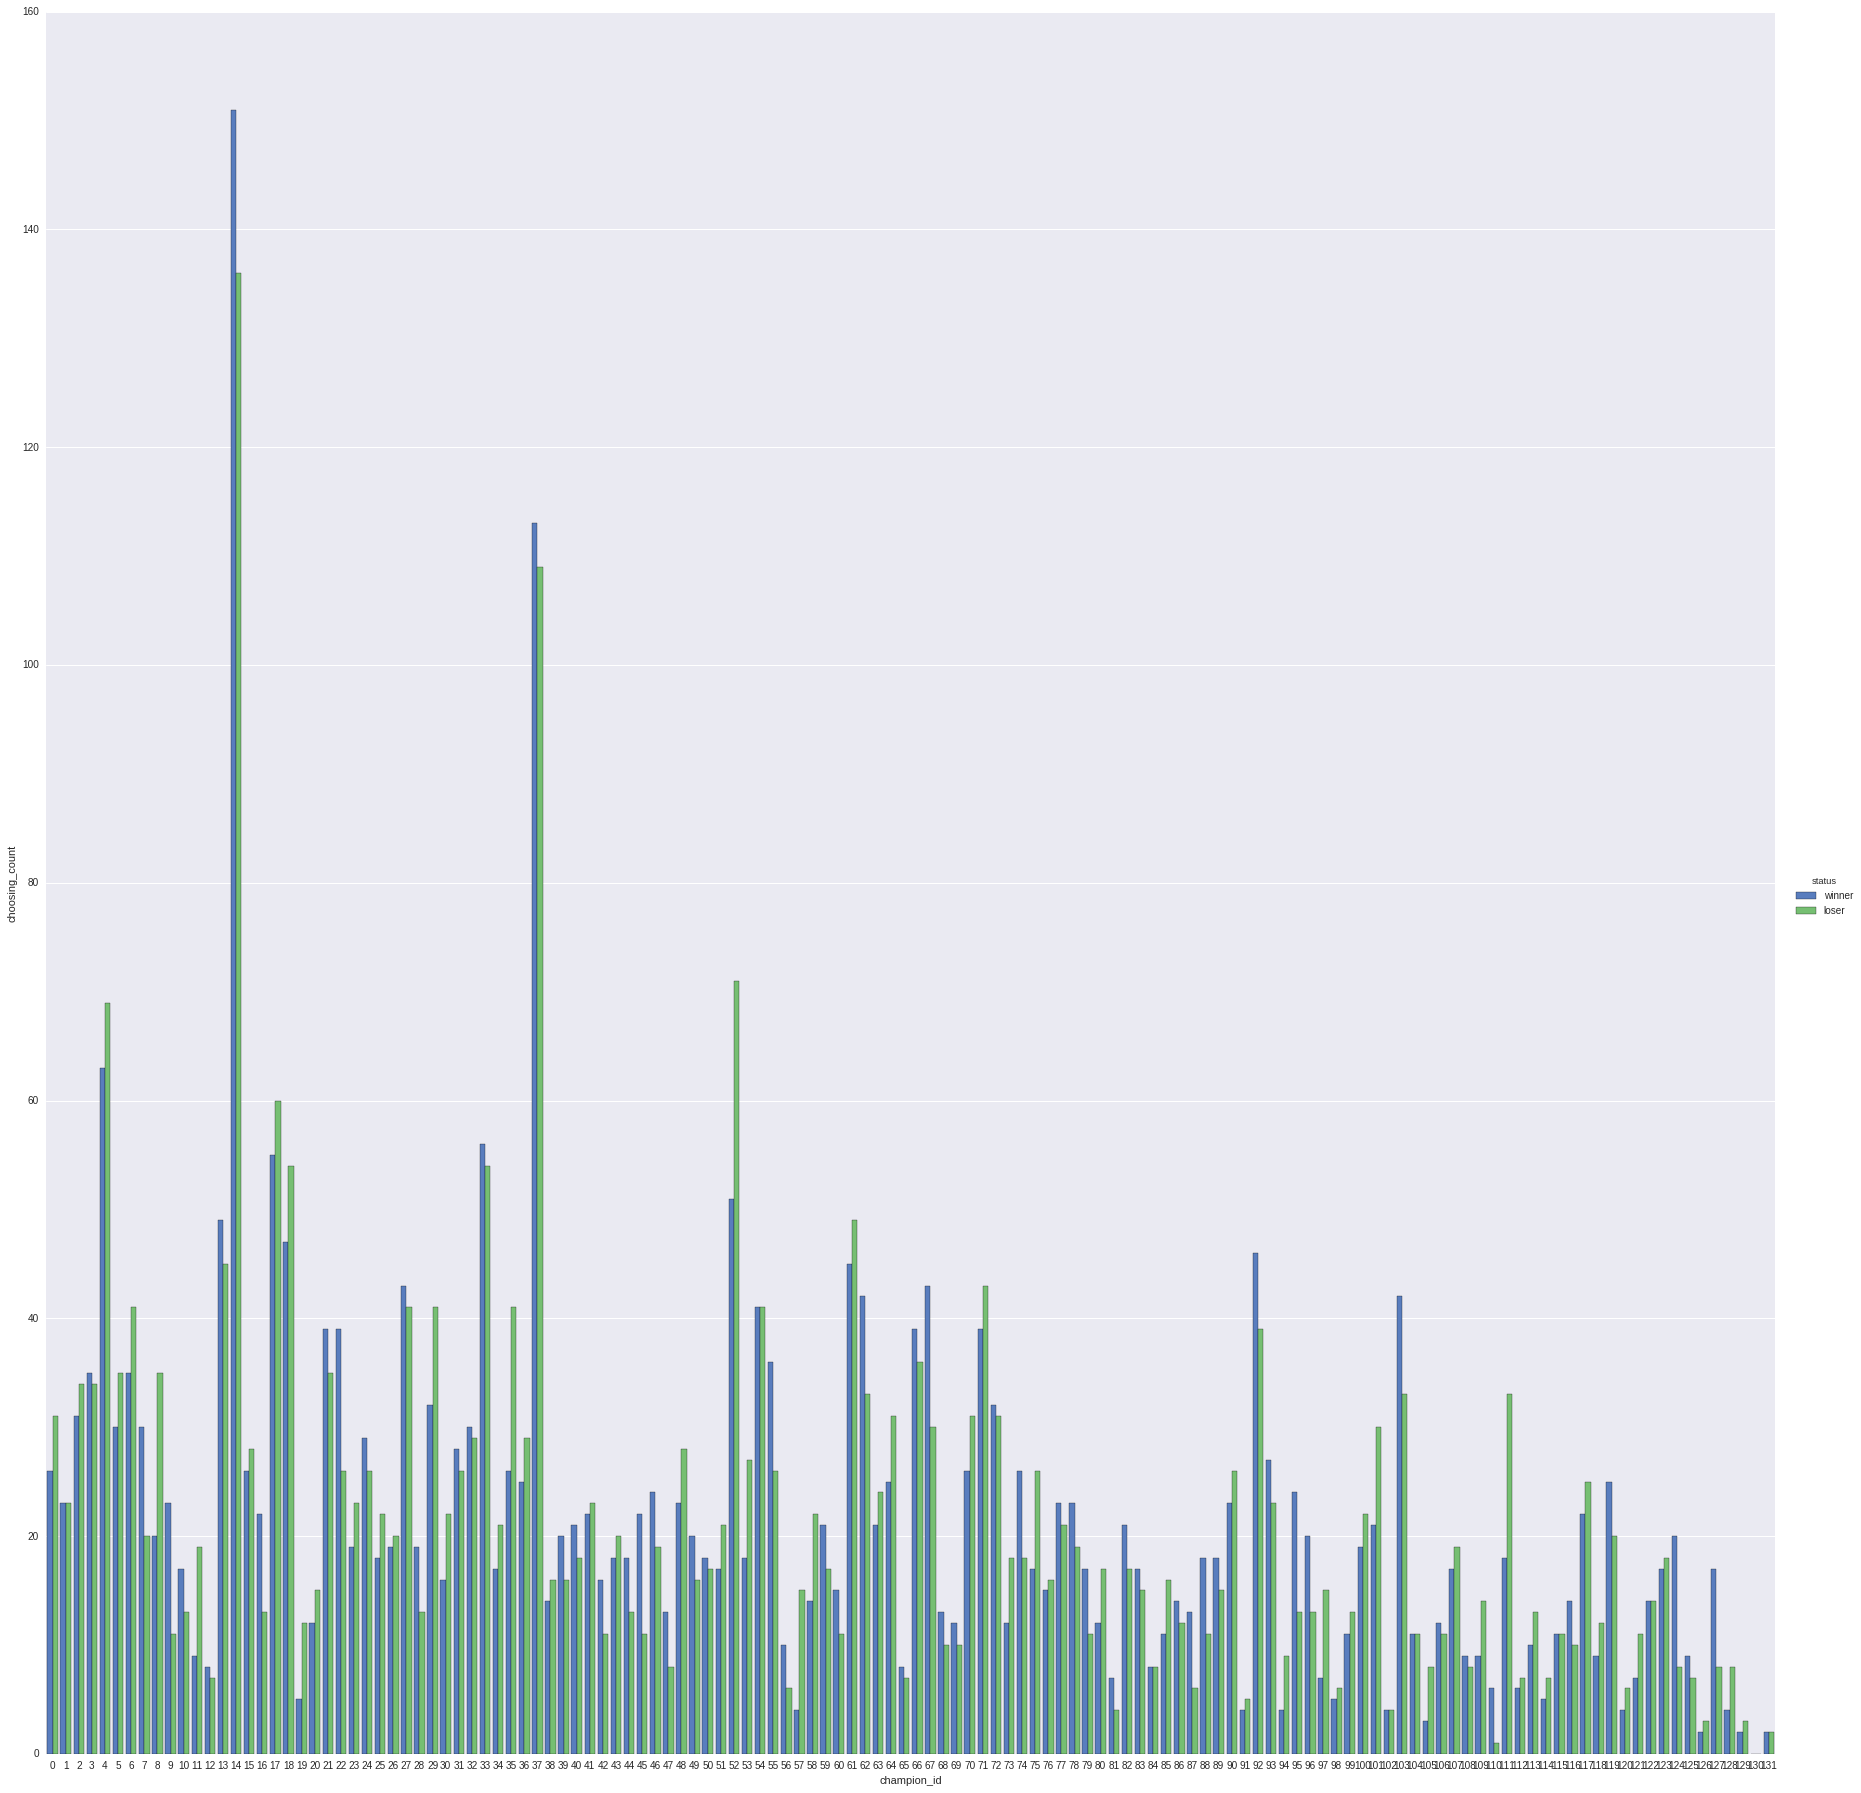

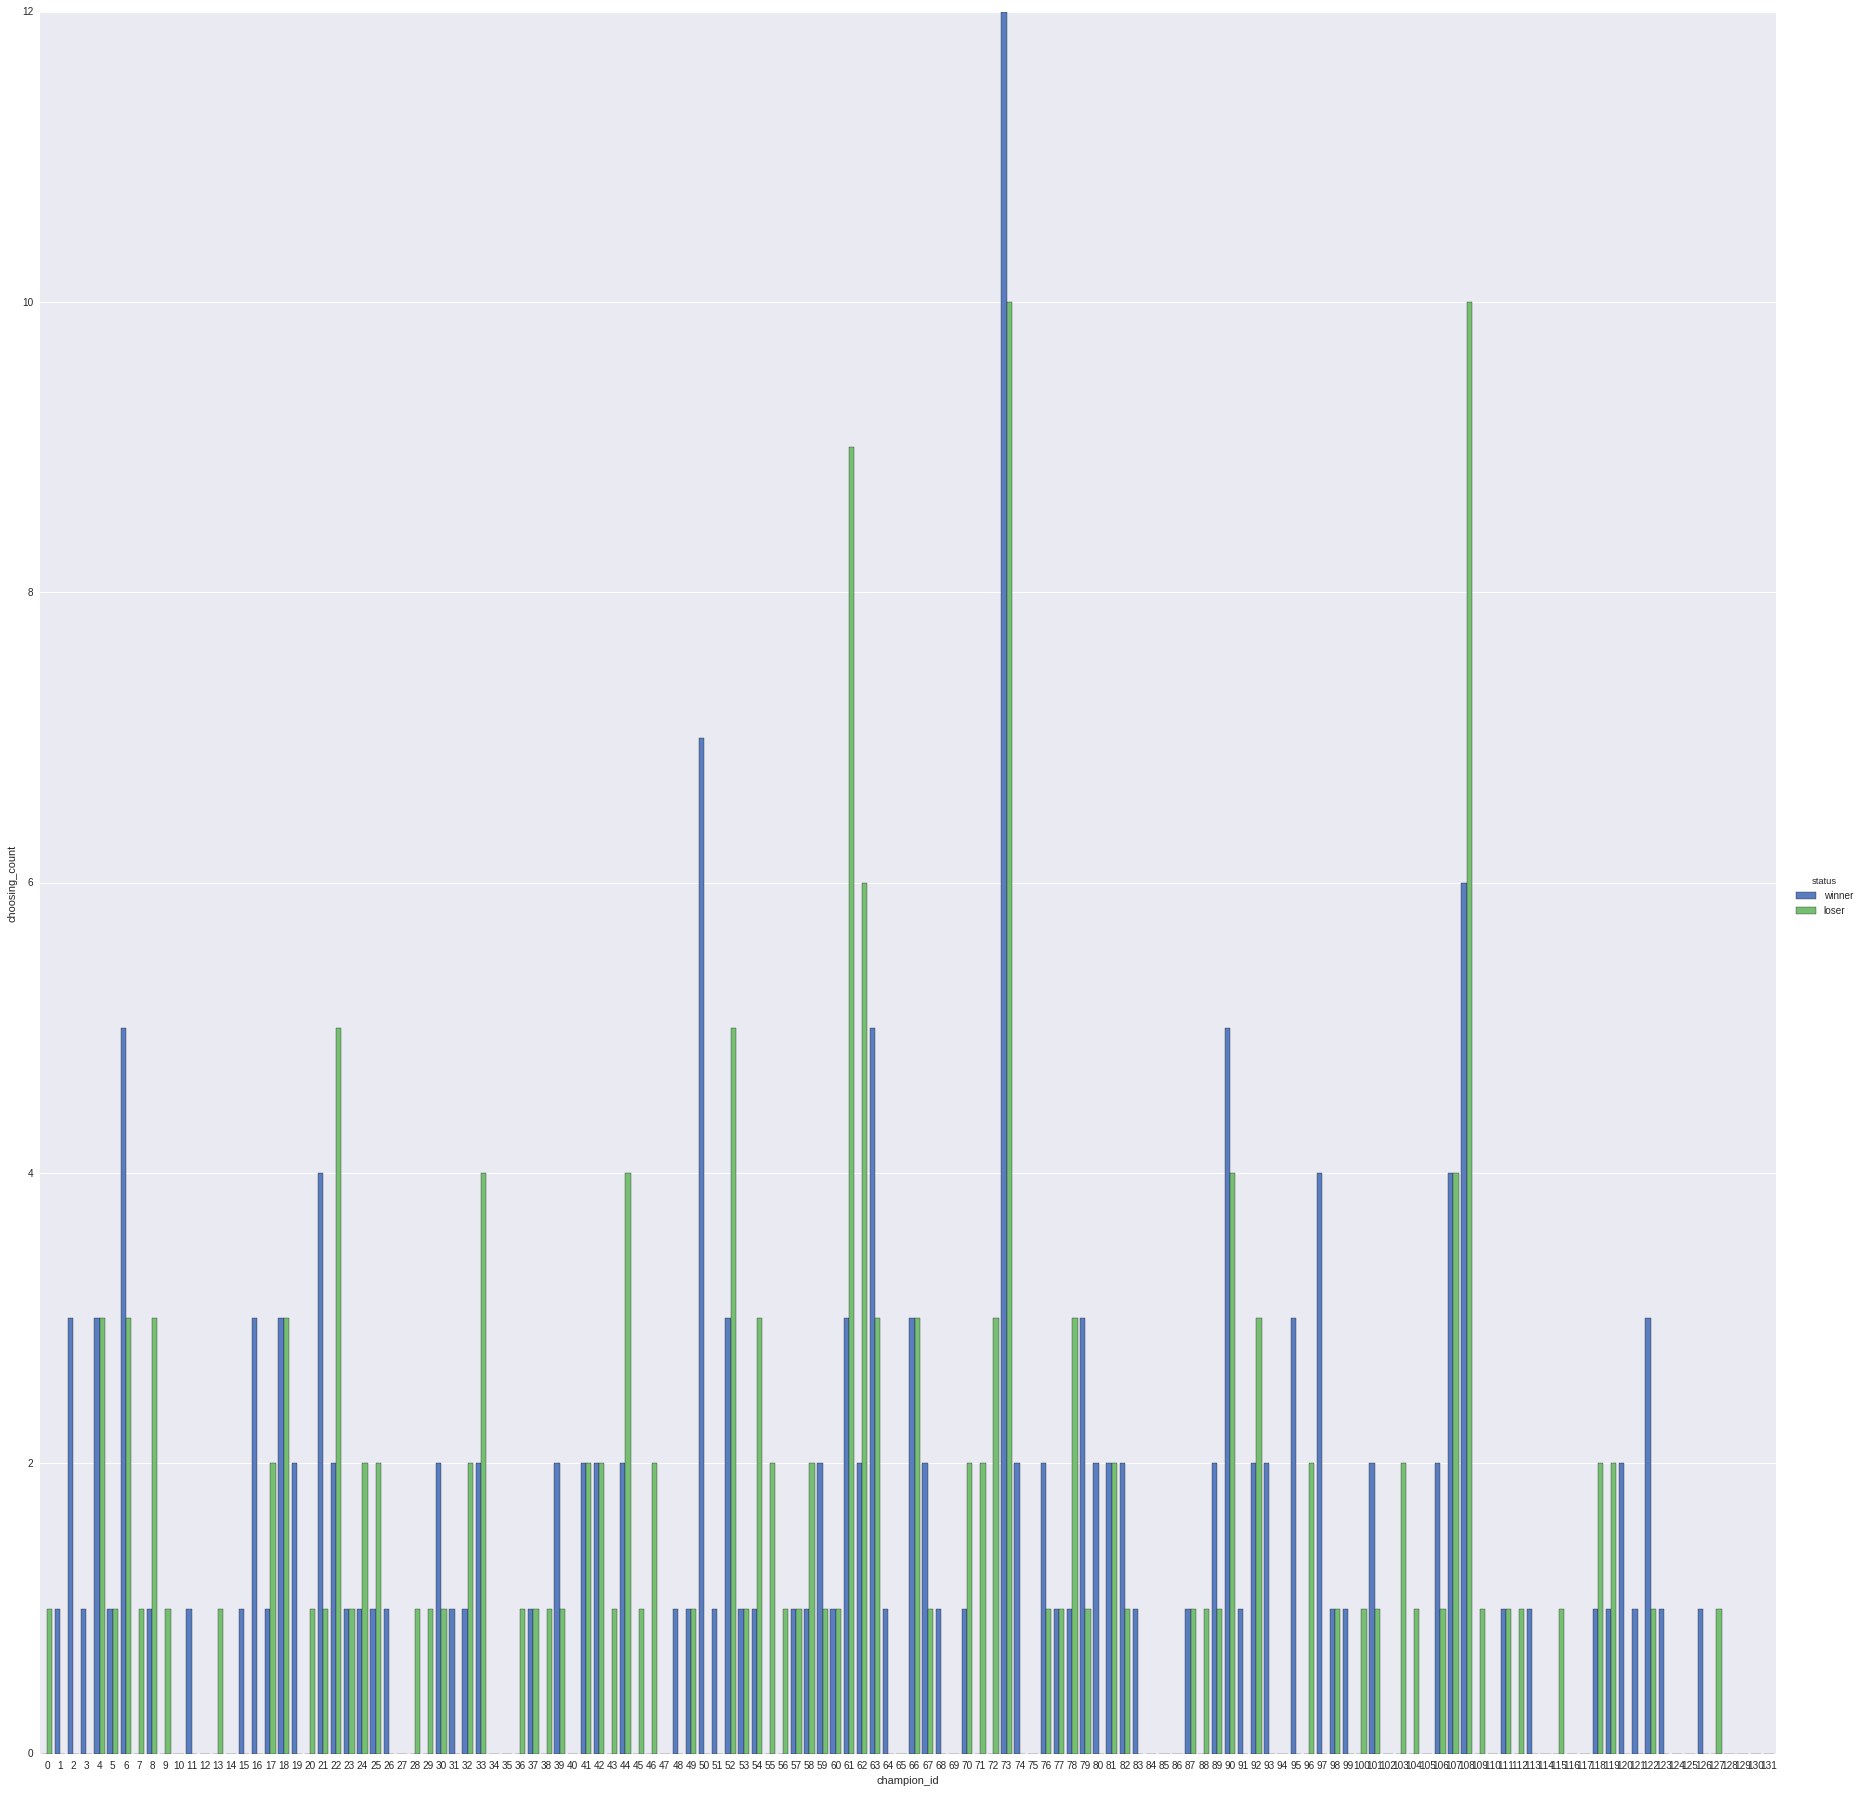

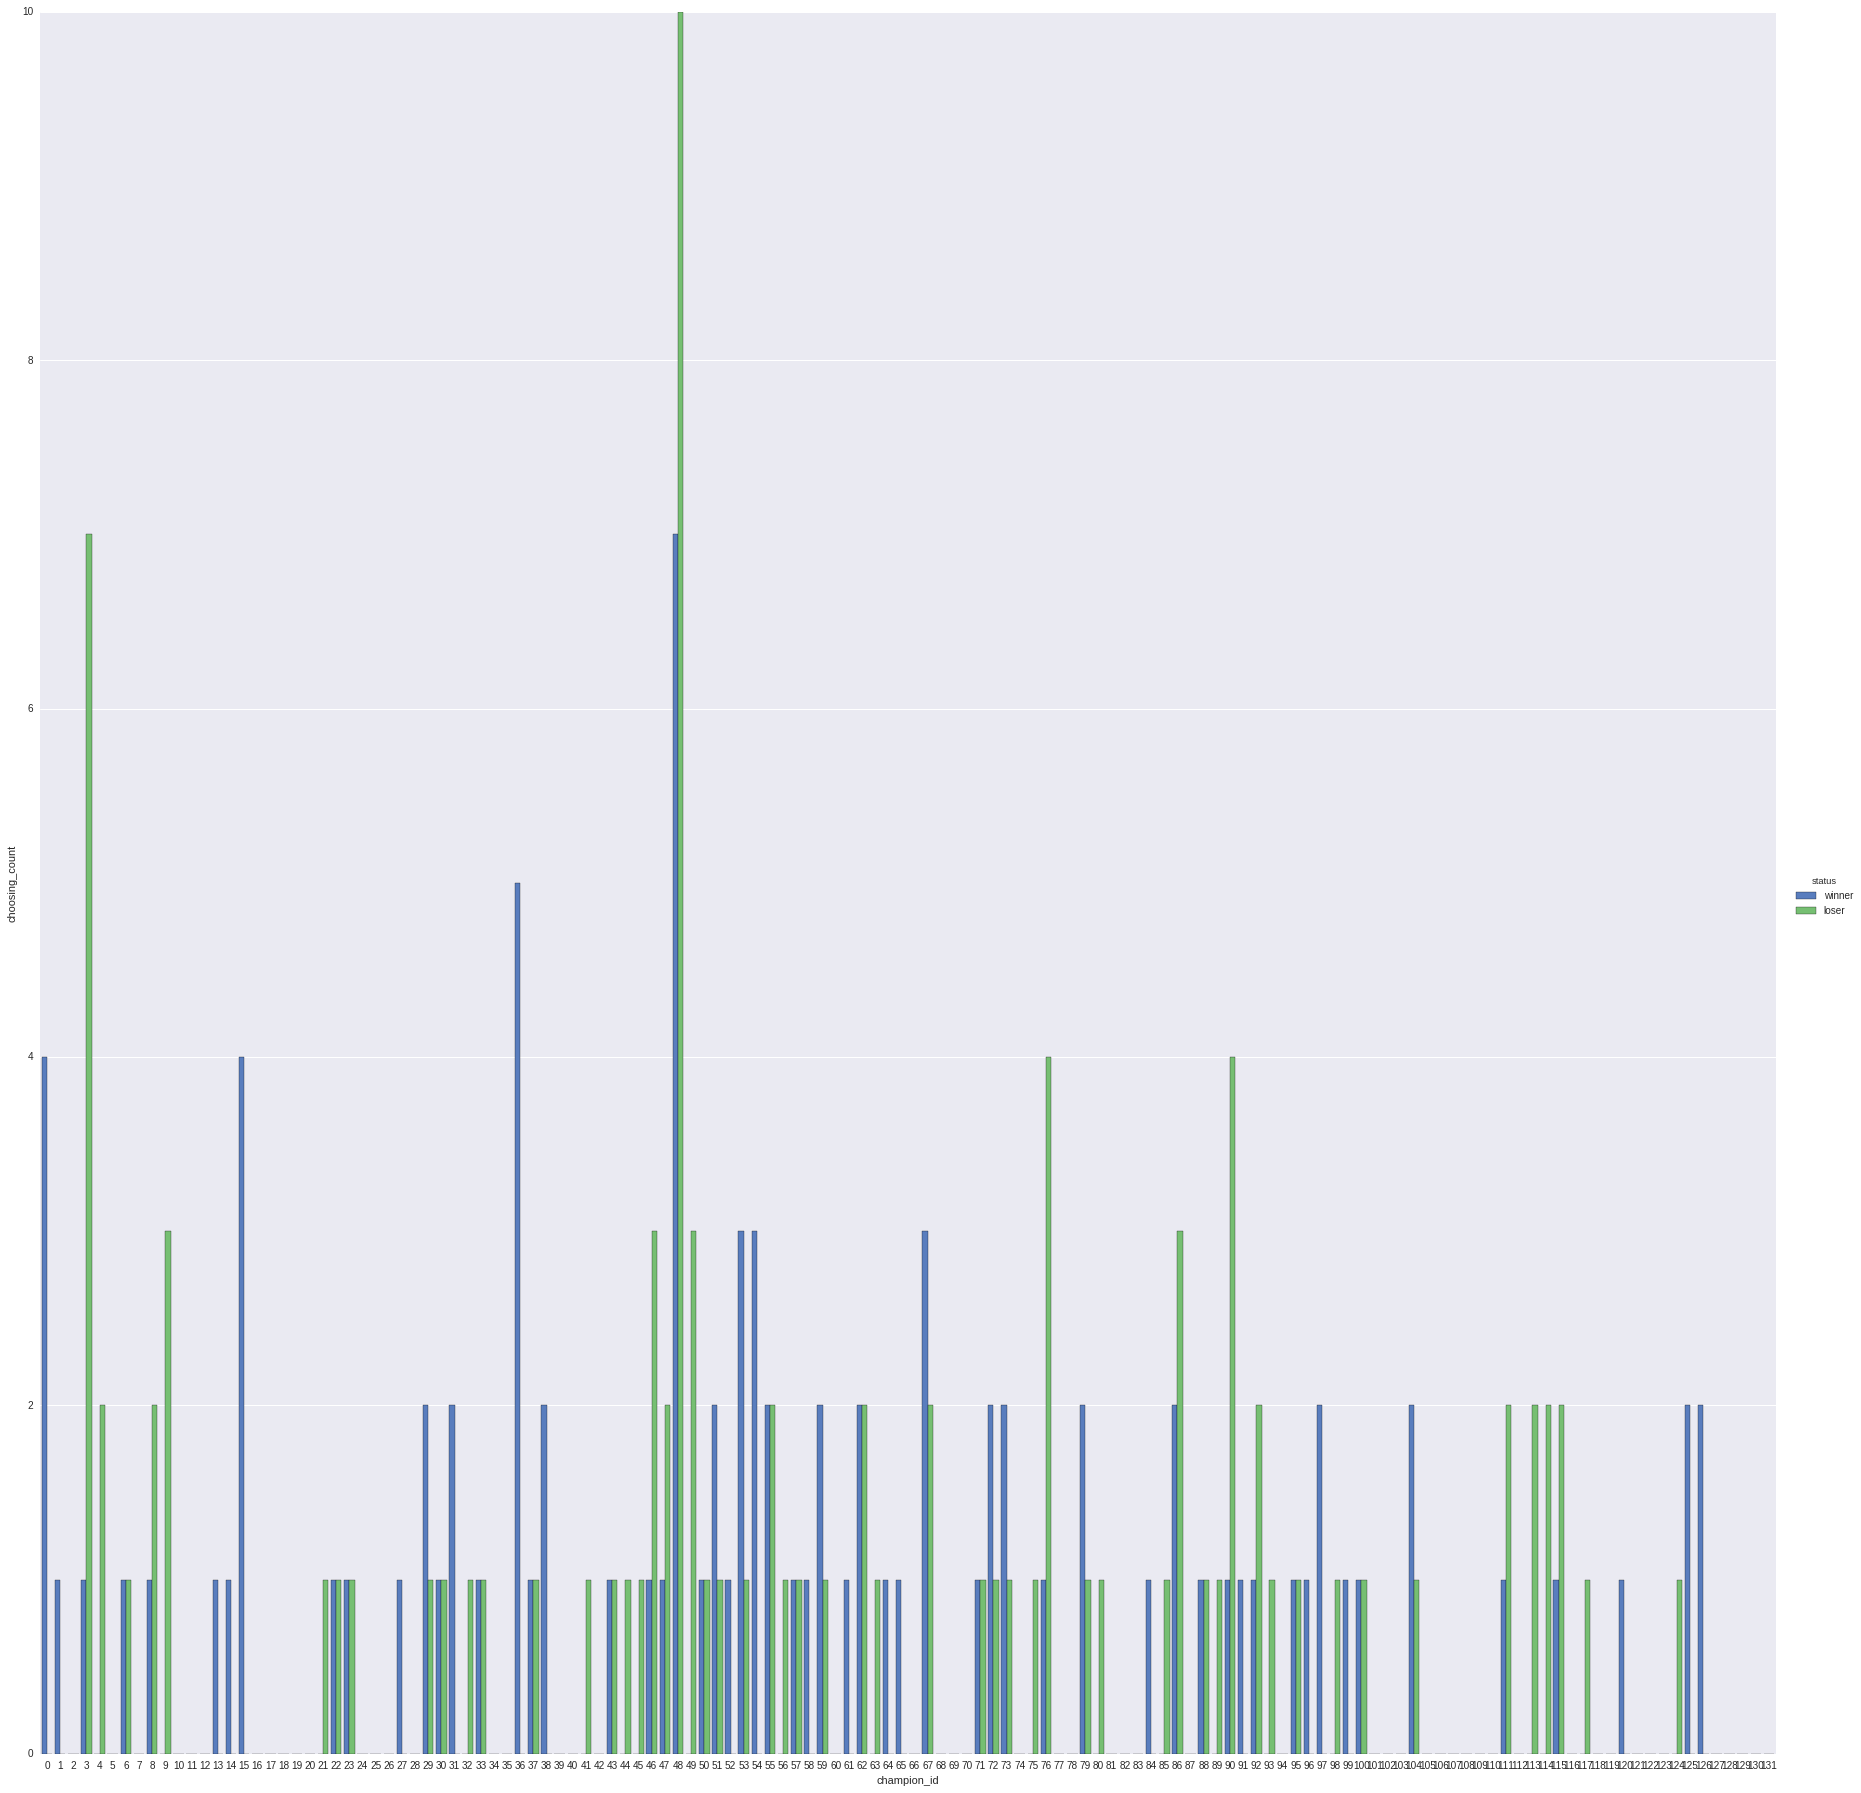

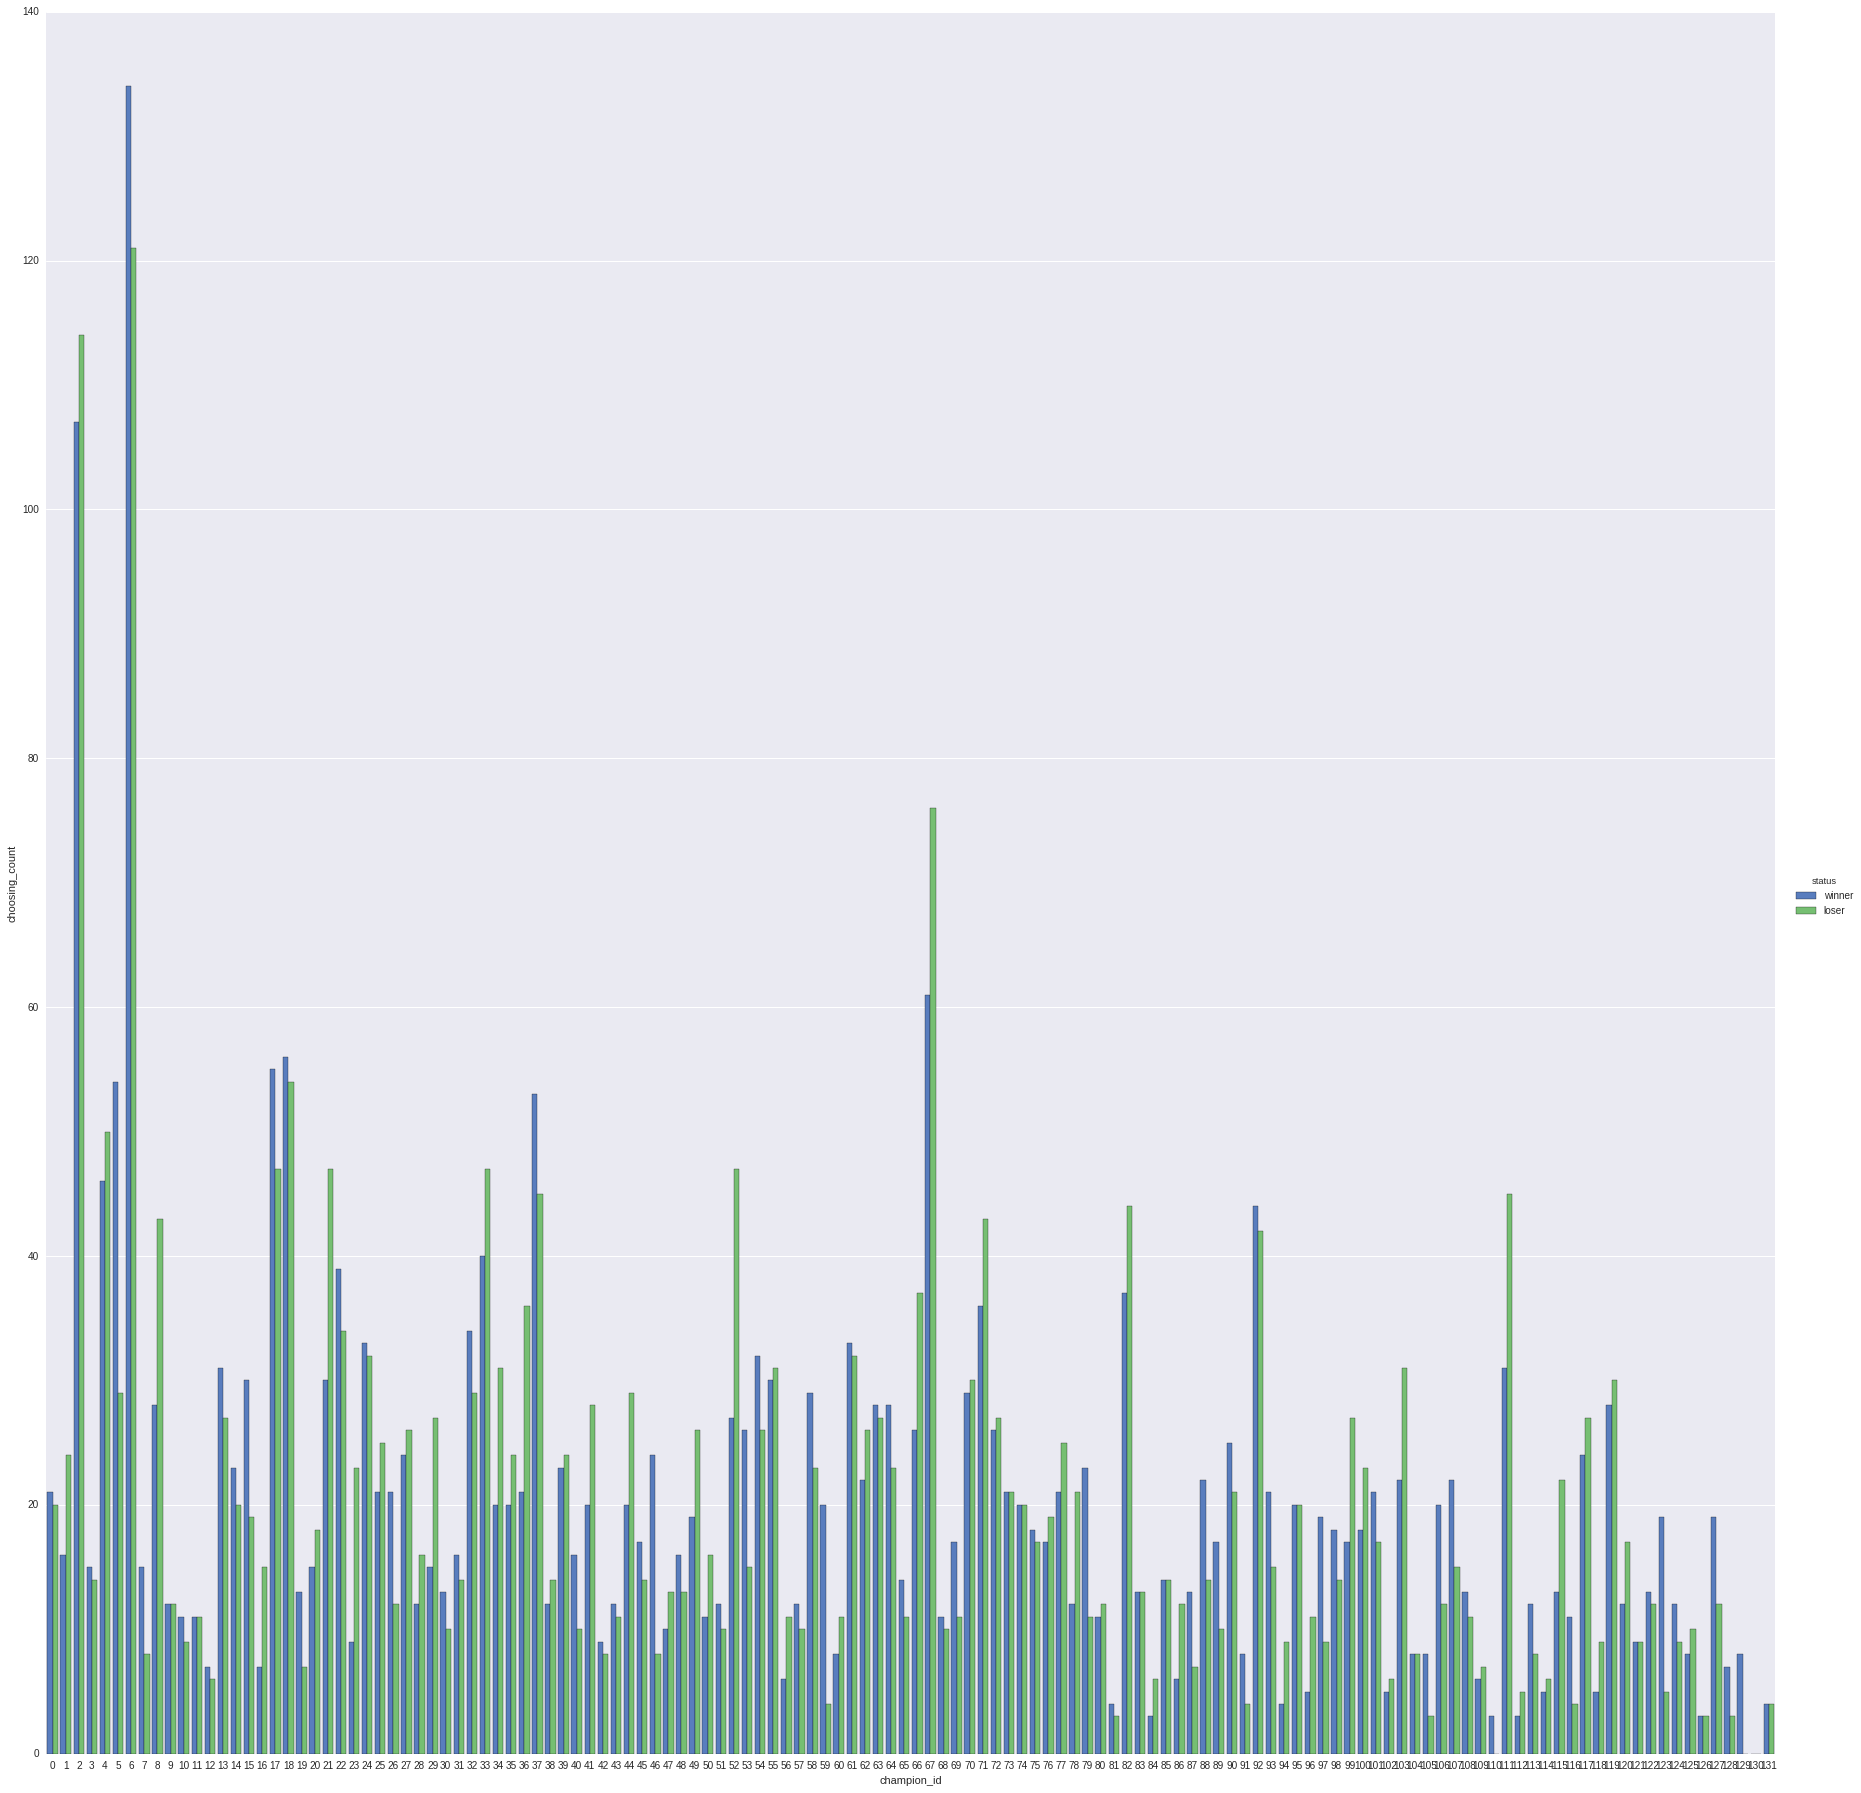

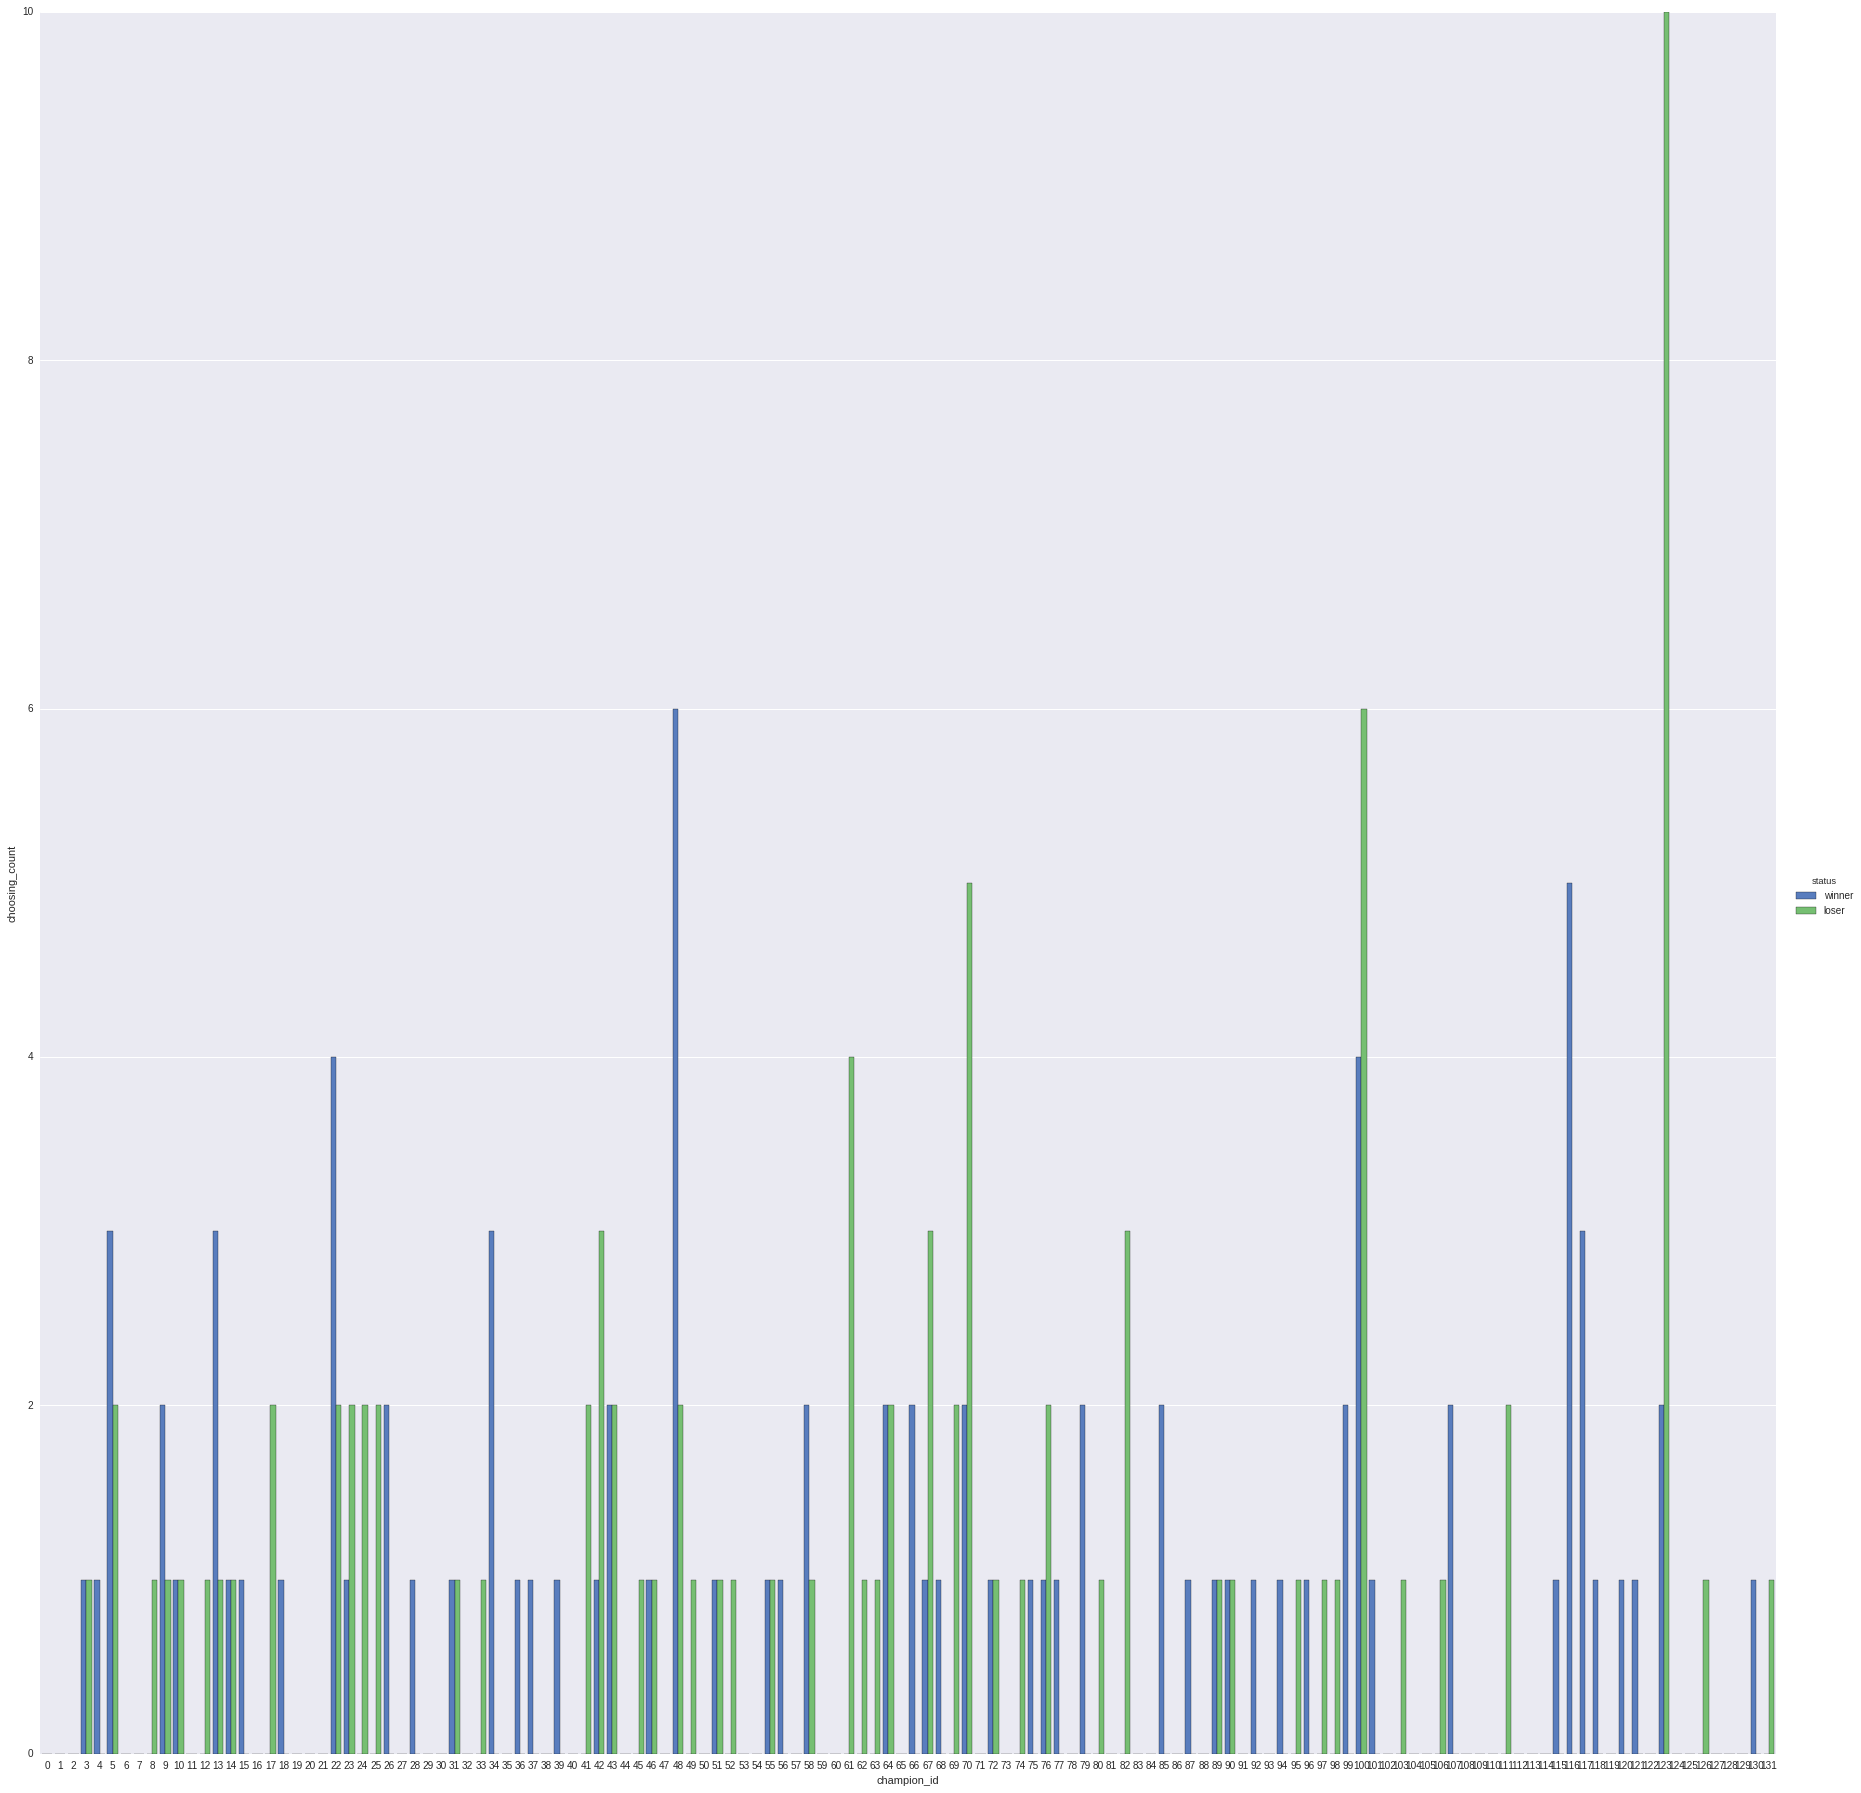

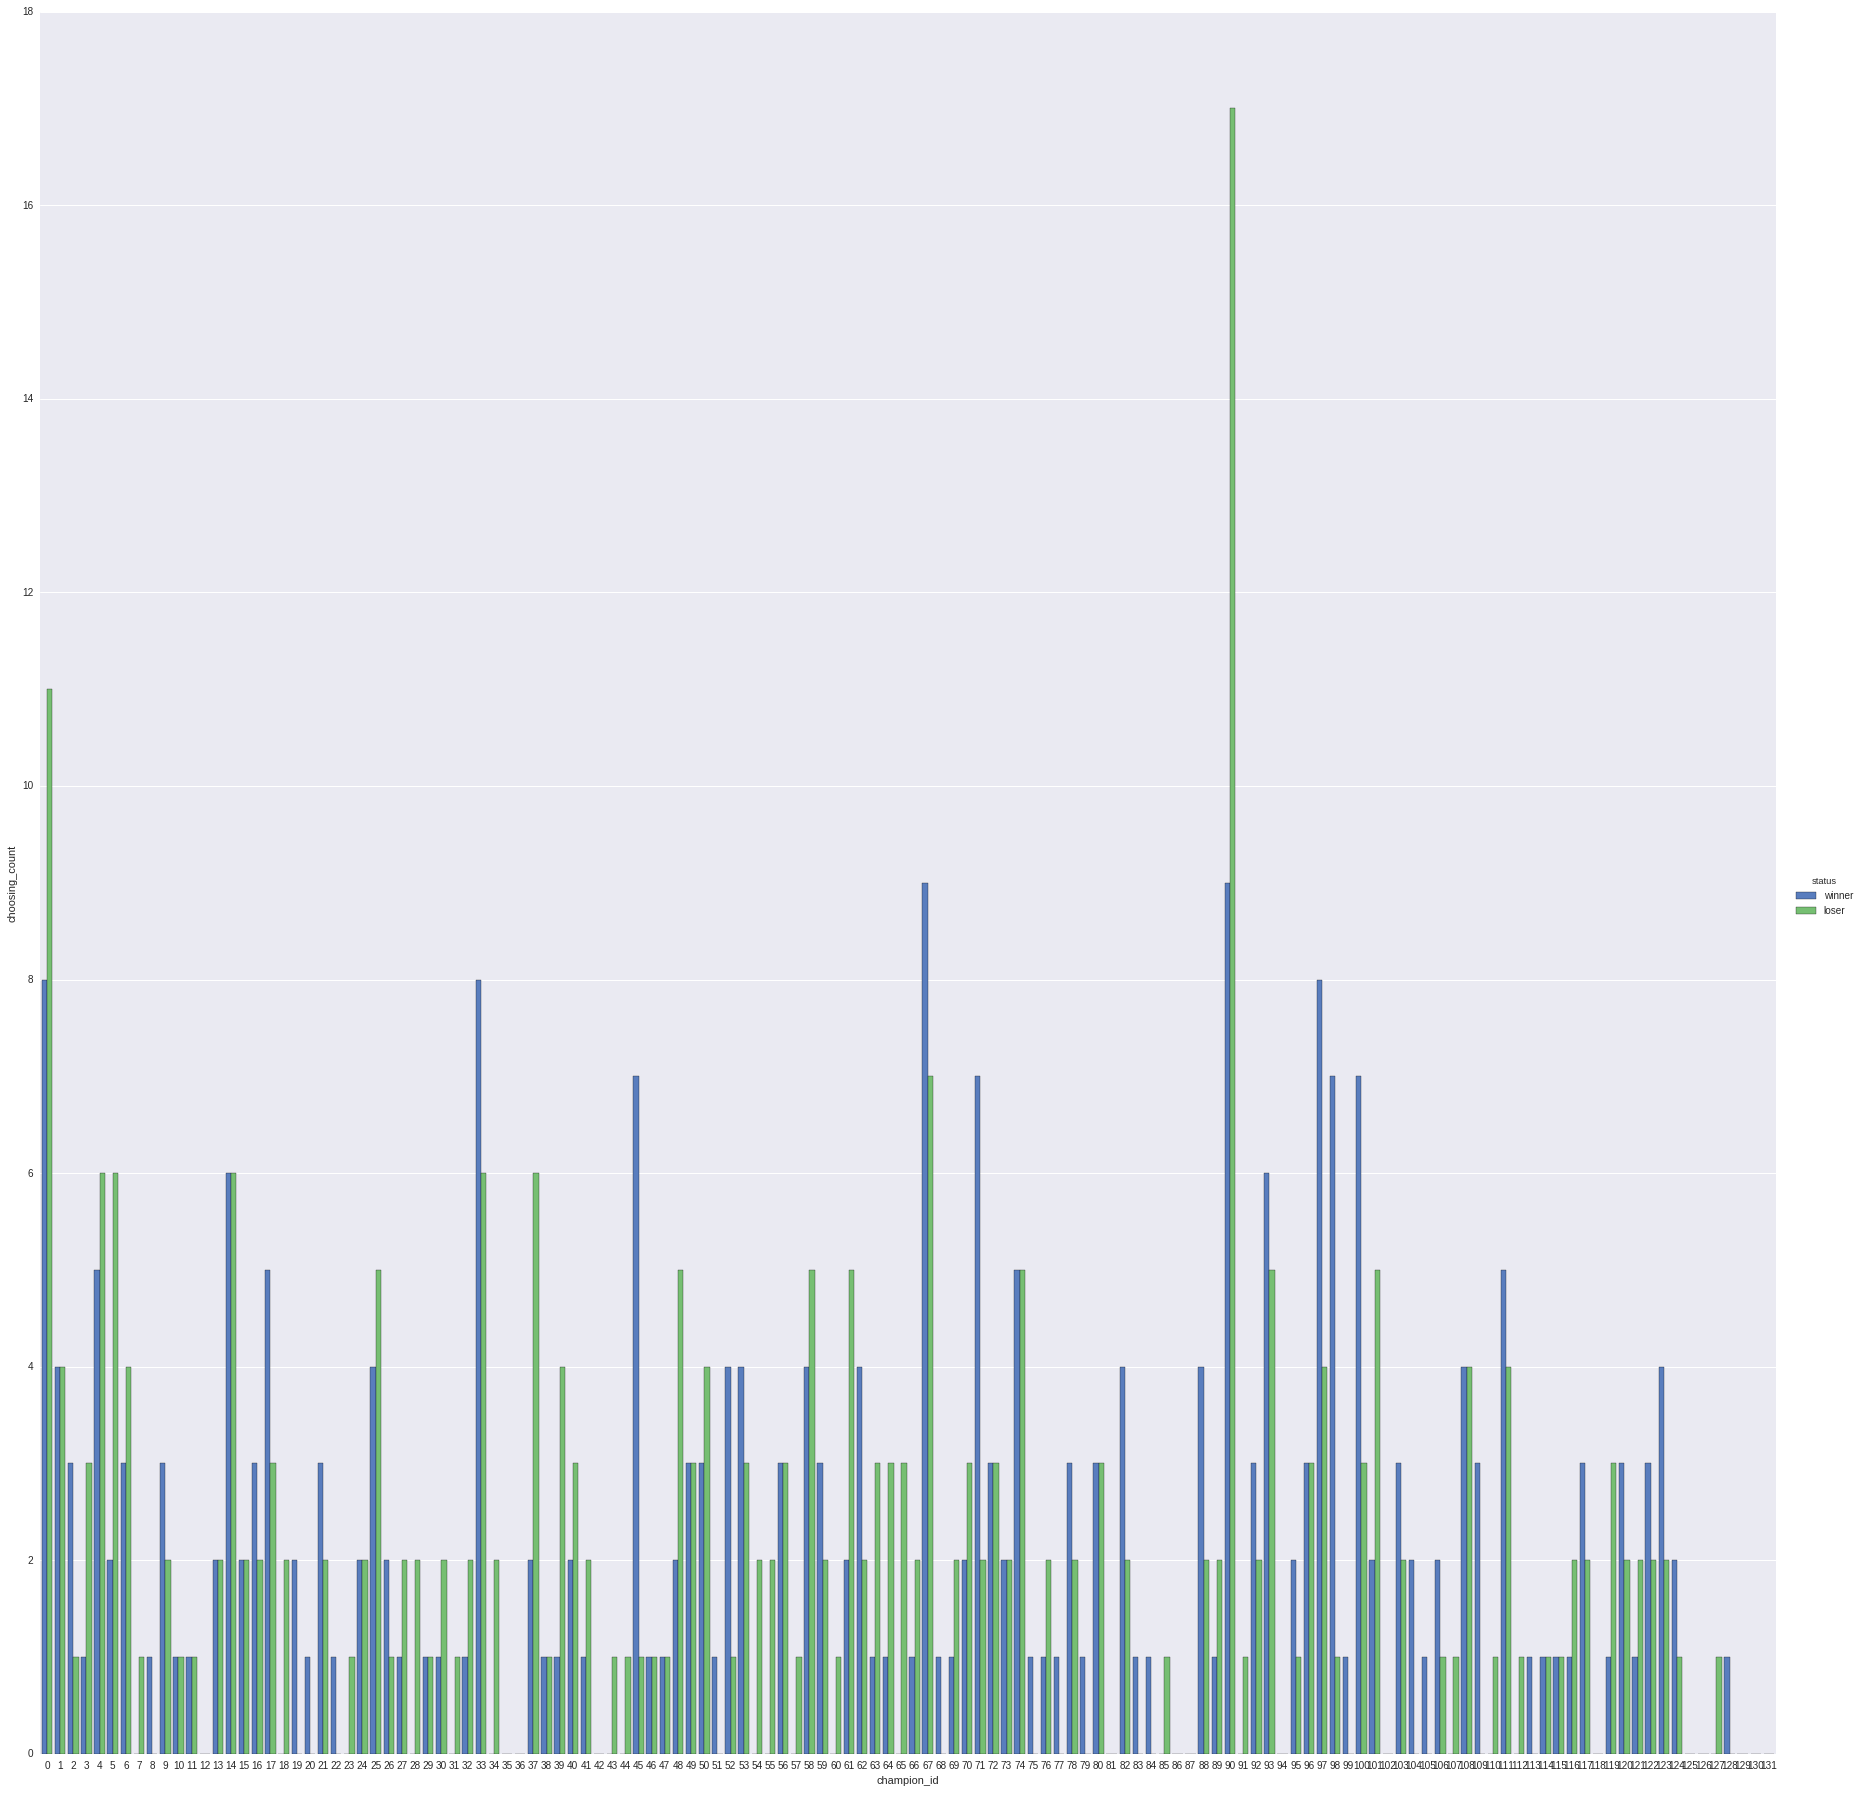

In [33]:
for i in range(9):
    print_one_cluster_champions(clustering, i)

# for good cluster

In [168]:
#good cluster to classify
idx = np.where(clustering.labels_==4)[0]
good_cluster_data = dataset_sampled.as_matrix()[idx,:]
accuracy = do_classification(good_cluster_data, verbose=False)
print(accuracy)
#winners = np.vstack((good_cluster_data[np.where(good_cluster_data[:,-1] == 1)[0],132:-1], good_cluster_data[np.where(good_cluster_data[:,-1] == 0)[0],:132]))
#losers = np.vstack((good_cluster_data[np.where(good_cluster_data[:,-1] == 1)[0],:132], good_cluster_data[np.where(good_cluster_data[:,-1] == 0)[0],132:-1]))

winners = [match[:132] if not match[-1] else match[132:-1] for match in good_cluster_data]
losers = [match[132:-1] if not match[-1] else match[:132] for match in good_cluster_data]

{'KNN': 46.666666666666664, 'Linear SVM': 68.333333333333329, 'Stochastic Gradient Descent Classifier': 39.166666666666657, 'Random Forest': 51.666666666666664, 'Linear Discriminant Analysis': 38.333333333333329, 'Naive Bayes': 44.999999999999993, 'Decision Tree': 64.166666666666657, 'Quadratic Discriminant Analysis': 62.499999999999993, 'Logistic Regression': 60.833333333333329, 'AdaBoost': 68.333333333333329, 'SVM with RBF kernel': 43.333333333333336}


In [185]:
print('Winners:')
for winner in winners:
    for champ_id in np.where(winner == 1)[0]:
        print(champions[champ_id]['tags'])
    print('\n')
print('\n\nLosers:')
for loser in losers:
    for champ_id in np.where(loser == 1)[0]:
        print(champions[champ_id]['tags'])
    print('\n')

Winners:
['Marksman']
['Fighter', 'Assassin']
['Assassin', 'Fighter']
['Fighter', 'Tank']
['Tank', 'Fighter']


['Fighter', 'Mage']
['Tank', 'Fighter']
['Fighter', 'Tank']
['Marksman', 'Support']
['Tank', 'Mage']


['Support', 'Mage']
['Assassin', 'Fighter']
['Marksman', 'Mage']
['Fighter', 'Assassin']
['Fighter']


['Support', 'Fighter']
['Fighter', 'Assassin']
['Tank', 'Fighter']
['Marksman']
['Mage']


['Support', 'Fighter']
['Fighter', 'Assassin']
['Fighter', 'Tank']
['Mage']
['Marksman']


['Tank', 'Fighter']
['Assassin', 'Fighter']
['Marksman', 'Mage']
['Marksman']
['Fighter', 'Tank']


['Mage', 'Support']
['Mage', 'Support']
['Marksman']
['Fighter', 'Tank']
['Fighter', 'Tank']


['Mage', 'Support']
['Tank', 'Fighter']
['Assassin', 'Fighter']
['Assassin', 'Fighter']
['Marksman']


['Mage', 'Support']
['Marksman', 'Mage']
['Tank', 'Fighter']
['Assassin', 'Fighter']
['Fighter', 'Tank']


['Mage', 'Support']
['Fighter', 'Tank']
['Tank', 'Fighter']
['Support', 'Mage']
['Marksman']




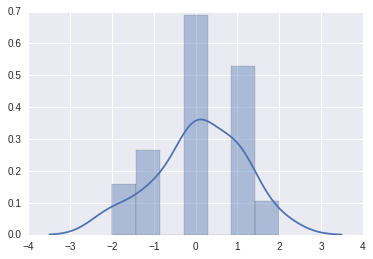

In [186]:
# Just champions' first category
diff = []
for i in range(len(good_cluster_data)):
#     diff.append(
#         len(set(chain.from_iterable([champions[champ_id]['tags'] for champ_id in np.where(winners[i] == 1)[0]])))
#         - len(set(chain.from_iterable([champions[champ_id]['tags'] for champ_id in np.where(losers[i] == 1)[0]])))
#         )
    diff.append(
        len(set([champions[champ_id]['tags'][0] for champ_id in np.where(winners[i] == 1)[0]]))
        - len(set([champions[champ_id]['tags'][0] for champ_id in np.where(losers[i] == 1)[0]]))
        )
sns.distplot(diff)

(array([  3.,   0.,   5.,   0.,   0.,  13.,   0.,  10.,   0.,   2.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 10 Patch objects>)

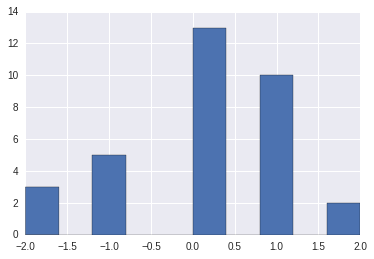

In [187]:
plt.hist(diff)

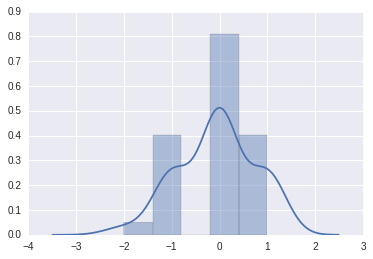

In [188]:
# both champions' categories
diff = []
for i in range(len(good_cluster_data)):
    diff.append(
        len(set(chain.from_iterable([champions[champ_id]['tags'] for champ_id in np.where(winners[i] == 1)[0]])))
        - len(set(chain.from_iterable([champions[champ_id]['tags'] for champ_id in np.where(losers[i] == 1)[0]])))
        )
sns.distplot(diff)

(array([  1.,   0.,   0.,   8.,   0.,   0.,  16.,   0.,   0.,   8.]),
 array([-2. , -1.7, -1.4, -1.1, -0.8, -0.5, -0.2,  0.1,  0.4,  0.7,  1. ]),
 <a list of 10 Patch objects>)

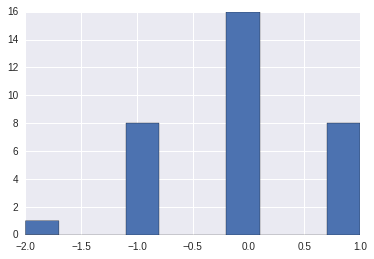

In [189]:
plt.hist(diff)

# diversity in terms of champion features

In [307]:
def plot_diversity(data, metric='euclidean'):
    winners = [match[:132] if not match[-1] else match[132:-1] for match in data]
    losers = [match[132:-1] if not match[-1] else match[:132] for match in data]
    winner_distance = [compute_average_distance([champions_stats_normalized[champ_id] for champ_id in np.where(winner == 1)[0]], metric=metric) for winner in winners]
    loser_distance = [compute_average_distance([champions_stats_normalized[champ_id] for champ_id in np.where(loser == 1)[0]], metric=metric) for loser in losers]

    plt.hist(winner_distance)
    plt.hist(loser_distance)
    plt.legend(['winners', 'losers'])
    plt.title(metric)
    plt.show()

In [308]:
def compute_average_distance(team, metric):
    return np.average(pdist(team, metric=metric))

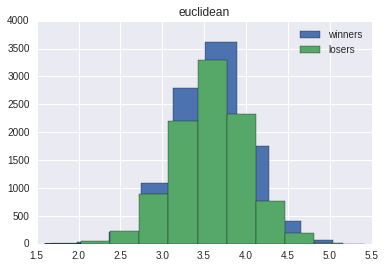

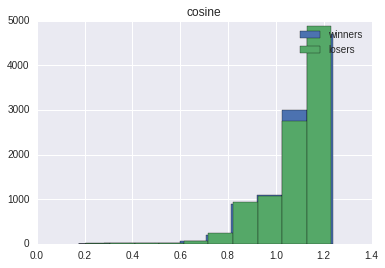

In [309]:
#for all data
plot_diversity(dataset.as_matrix(), metric='euclidean')
plot_diversity(dataset.as_matrix(), metric='cosine')

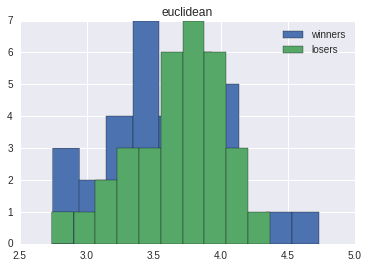

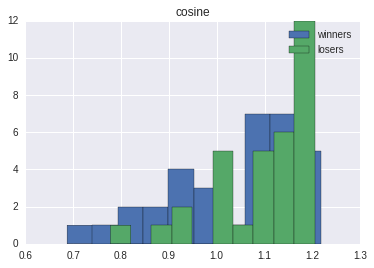

In [310]:
#good cluster to classify
idx = np.where(clustering.labels_==4)[0]
good_cluster_data = dataset_sampled.as_matrix()[idx,:]
plot_diversity(good_cluster_data, metric='euclidean')
plot_diversity(good_cluster_data, metric='cosine')

# Clustering and then classification and choosing the best senario with respect to weighted accuracy

In [462]:
# %load compute_all_cluster_then_classify_senarios.py
def compute_all_cluster_then_classify_senarios(data, metric='euclidean'):

    #import do_classification


    X = np.asmatrix(data.ix[:,:-1])
    y = np.asanyarray(data['label'])

    if metric == 'euclidean':
        linkages = ['ward', 'average', 'complete']
    else:
        linkages = ['average', 'complete']

    total_accuracy_details = []
    total_accuracy = []
    classifier_keys = []
    for number_of_clusters in range(1,10):
        if number_of_clusters == 1:
            #without clustering
            accuracy = do_classification(data, verbose=False)
            total_accuracy_details.append([len(data), accuracy])
            classifier_keys = list(accuracy.keys())
            accuracy_df = pd.DataFrame(columns=classifier_keys)
            total_accuracy.append([number_of_clusters, '-']+[accuracy[k] for k in classifier_keys])
        else:
            #with hierarchical clustering
            for linkage in linkages:
                clustering = AgglomerativeClustering(linkage=linkage, n_clusters=number_of_clusters, affinity=metric)
                clustering.fit(X)
                cluster_size_accuracy = []
                acc = 0
                for cluster_index in range(number_of_clusters):
                    idx = np.where(clustering.labels_==cluster_index)[0]
                    if len(idx) > 10:
                        accuracy = do_classification(np.column_stack((X[idx,:], y[idx])), verbose=False)
                        cluster_size_accuracy = cluster_size_accuracy + [len(idx), accuracy]
                        acc += len(idx) * np.array([accuracy[k] for k in classifier_keys])
                acc /= len(data)
                total_accuracy_details.append(cluster_size_accuracy)
                total_accuracy.append([number_of_clusters, linkage]+list(acc))
    return pd.DataFrame(data=total_accuracy, columns=['#cluster', 'linkage']+classifier_keys), total_accuracy_details

In [455]:
dataset_sampled = dataset.sample(n=4000)
acc1, details1 = compute_all_cluster_then_classify_senarios(dataset_sampled, metric='manhattan')
acc1

,#cluster,linkage,KNN,Linear SVM,Stochastic Gradient Descent Classifier,Random Forest,Linear Discriminant Analysis,Naive Bayes,Decision Tree,Quadratic Discriminant Analysis,Logistic Regression,AdaBoost,SVM with RBF kernel
0,1,-,49.725000,51.925000,49.025000,51.750000,51.975000,51.225000,50.675000,51.650000,51.975000,51.775000,50.900000
1,2,average,49.629738,52.074809,49.871385,50.380911,51.956735,51.320088,48.970952,51.185397,51.628800,51.899430,50.996398
2,2,complete,50.029168,51.940400,49.788163,50.476024,51.901294,51.392938,50.140225,51.308086,51.965583,50.715836,50.855033
3,3,average,49.703905,52.256342,51.315039,50.427050,52.056512,51.396234,49.039648,51.203383,51.701672,51.811290,51.017588
4,3,complete,49.232786,52.018964,51.167357,51.144036,52.123589,51.846821,51.141946,51.152286,52.293250,52.944625,51.002518
5,4,average,49.151024,52.034452,52.226722,50.779174,51.634474,51.970161,48.846366,50.074906,51.752369,51.667670,51.064546
6,4,complete,48.656963,52.144338,50.363452,51.748922,52.323963,51.547870,51.640730,50.778107,52.343881,53.040940,51.003050
7,5,average,49.105551,52.235731,50.245895,50.272207,51.782224,51.889561,48.152966,49.998834,51.777113,50.820714,50.969411
8,5,complete,49.138557,52.508911,50.538531,50.600423,52.610977,51.821461,51.377492,50.890453,52.805618,52.541190,51.173557
9,6,average,49.005190,51.060312,49.616252,49.897006,50.632176,51.066336,49.508788,50.699410,51.026300,51.241687,50.244339


In [456]:
dataset_sampled = dataset.sample(n=4000)
acc2, details2 = compute_all_cluster_then_classify_senarios(dataset_sampled, metric='cosine')
acc2

,#cluster,linkage,KNN,Linear SVM,Stochastic Gradient Descent Classifier,Random Forest,Linear Discriminant Analysis,Naive Bayes,Decision Tree,Quadratic Discriminant Analysis,Logistic Regression,AdaBoost,SVM with RBF kernel
0,1,-,49.400000,52.225000,50.950000,50.625000,52.250000,52.000000,50.275000,52.100000,52.200000,50.250000,50.475000
1,2,average,49.631663,52.334350,51.559343,51.383484,52.406856,52.280004,49.708878,53.207123,52.333031,50.185567,50.733509
2,2,complete,50.120169,52.952295,52.930522,51.500013,52.647025,52.973490,49.500510,52.535072,52.801908,51.420471,51.278553
3,3,average,49.956140,52.734474,52.580863,51.008019,52.485322,51.028012,49.258582,49.957529,52.632529,51.254956,50.057390
4,3,complete,50.242388,52.525928,51.772446,52.513412,52.349374,52.499486,49.226206,51.859769,52.301179,51.353930,50.898838
5,4,average,49.968604,52.416115,51.882652,51.022835,52.705844,51.025639,49.141932,49.790568,52.444210,50.819432,50.061878
6,4,complete,49.316850,52.497495,52.568887,51.616100,52.295125,53.292481,50.947323,52.114652,52.221726,51.775576,50.669379
7,5,average,50.318604,52.741115,52.231239,51.159042,53.230844,50.625639,49.088837,49.390568,52.419210,51.738258,51.336878
8,5,complete,49.517549,52.447272,50.982234,51.385337,52.220135,53.144554,50.723275,51.891002,51.846599,52.102505,50.795608
9,6,average,50.789142,53.509564,52.534826,52.558472,52.905370,50.701536,50.538339,49.741100,52.893964,51.942177,50.958622


Computing embedding
Done.
average : 17.40s
complete : 16.72s


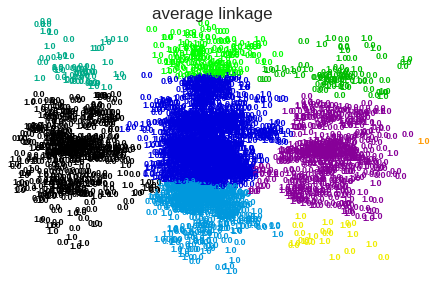

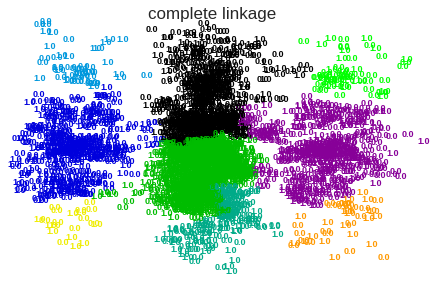

In [569]:
visualize_hierarchical_clusters(dataset_sampled, 9)

In [530]:
X = np.asmatrix(dataset_sampled.ix[:,:-1])
y = np.asanyarray(dataset_sampled['label'])
clus = AgglomerativeClustering(linkage='average', n_clusters=9, affinity='cosine')
clus.fit(X)

AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=9, n_components=None,
            pooling_func=<function mean at 0x7fd72c0f98c8>)

In [565]:
for cluster_index in range(9):
    idx = np.where(clus.labels_==cluster_index)[0]
    if len(idx) > 10:
        print('Length of this cluster is:', len(idx),'\n')
        print(do_classification(np.column_stack((X[idx,:], y[idx]))))
        print('\n----------------------------------------------\n')
    print('\n\n\n================================================')

Length of this cluster is: 554 

                                classifier  test acc  train acc
0                                      KNN     50.75      63.66
1                               Linear SVM     48.74      86.54
2   Stochastic Gradient Descent Classifier     51.44      73.45
3                            Random Forest     48.92     100.00
4             Linear Discriminant Analysis     50.19      85.06
5                              Naive Bayes     50.01      70.02
6                            Decision Tree     47.45      60.21
7          Quadratic Discriminant Analysis     53.98     100.00
8                      Logistic Regression     51.64      82.51
9                                 AdaBoost     47.28      73.14
10                     SVM with RBF kernel     51.99      51.99

----------------------------------------------




Length of this cluster is: 295 

                                classifier  test acc  train acc
0                                      KNN     53.

Length of this cluster is: 554 

Data has 554 samples,
0 :  51.985559566787 %
1 :  48.014440433213 %


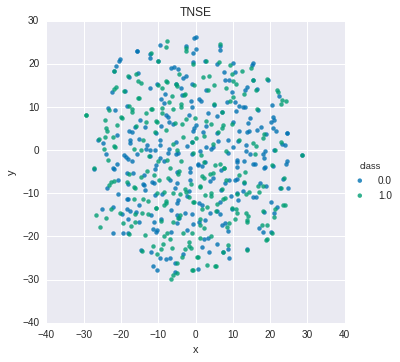

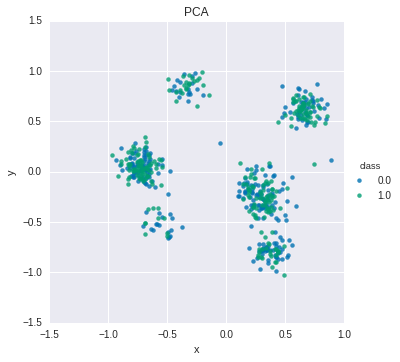

In [566]:
idx = np.where(clustering.labels_==0)[0]
print('Length of this cluster is:', len(idx),'\n')
dtt = np.column_stack((X[idx,:], y[idx]))
c0 = pd.DataFrame(dtt, columns=dataset.columns)
print_class_ratio(c0)
plot_data(c0)

Length of this cluster is: 114 

Data has 114 samples,
0 :  51.75438596491228 %
1 :  48.24561403508772 %


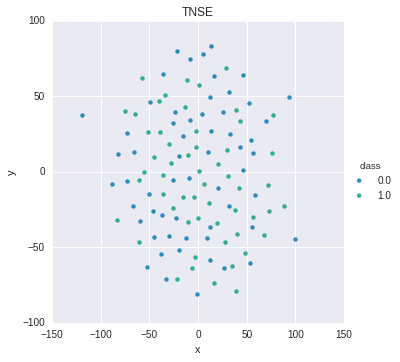

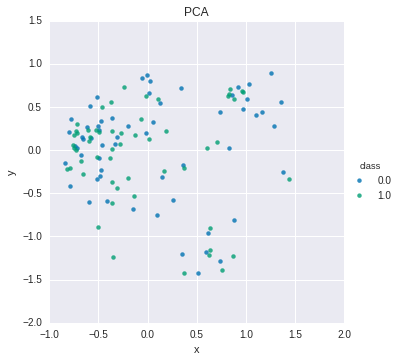

In [567]:
idx = np.where(clustering.labels_==5)[0]
print('Length of this cluster is:', len(idx),'\n')
dtt = np.column_stack((X[idx,:], y[idx]))
c5 = pd.DataFrame(dtt, columns=dataset.columns)
print_class_ratio(c5)
plot_data(c5)

In [457]:
acc_total, details_total = compute_all_cluster_then_classify_senarios(dataset, metric='manhattan')
acc_total

,#cluster,linkage,KNN,Linear SVM,Stochastic Gradient Descent Classifier,Random Forest,Linear Discriminant Analysis,Naive Bayes,Decision Tree,Quadratic Discriminant Analysis,Logistic Regression,AdaBoost,SVM with RBF kernel
0,1,-,49.400000,52.225000,50.775000,50.900000,52.250000,52.000000,50.225000,52.100000,52.200000,50.250000,50.475000
1,2,average,123.722081,132.250206,125.924252,129.027567,132.246073,129.727746,128.130228,130.209652,132.175248,130.280077,131.773370
2,2,complete,125.034846,132.732560,128.220961,127.760420,132.623785,130.172068,128.223393,129.724380,132.632550,131.825016,131.277694
3,3,average,124.020007,132.298491,126.946782,129.415612,132.274402,129.876705,127.761713,129.779438,132.575057,130.570029,131.850895
4,3,complete,125.001250,132.601250,128.256667,128.726667,132.596250,130.164583,128.707083,129.110833,132.902500,131.594583,131.825833
5,4,average,124.293257,132.328667,126.095662,130.246087,132.677362,130.006761,128.257802,129.005322,132.403669,130.521455,131.071690
6,4,complete,125.197459,133.170278,128.471563,128.907596,133.289331,130.083197,127.837181,130.407273,133.270645,131.767250,131.069106
7,5,average,124.251963,132.193159,125.053272,128.184205,132.227574,130.136885,127.798787,129.409138,132.441260,130.334334,130.199562
8,5,complete,124.427242,131.837528,127.645183,128.967308,131.738645,130.110001,126.568519,129.202929,131.744854,132.386631,129.646197
9,6,average,124.469327,132.114450,126.313739,131.460049,131.977542,130.033179,127.631396,129.753091,132.315701,130.045256,130.450433


In [463]:
acc_ALL, details_ALL = compute_all_cluster_then_classify_senarios(dataset, metric='manhattan')
acc_ALL

,#cluster,linkage,KNN,Linear SVM,Stochastic Gradient Descent Classifier,Random Forest,Linear Discriminant Analysis,Naive Bayes,Decision Tree,Quadratic Discriminant Analysis,Logistic Regression,AdaBoost,SVM with RBF kernel
0,1,-,49.630000,52.910000,51.270000,51.550000,52.900000,52.280000,51.380000,51.820000,52.900000,52.590000,52.750000
1,2,average,49.488832,52.900082,50.131534,52.200607,52.898429,51.891098,51.281940,52.083861,52.870099,52.102174,52.709348
2,2,complete,50.013938,53.093024,51.599288,51.542574,53.049514,52.068827,51.310352,51.869750,53.053020,52.749340,52.511078
3,3,average,49.608003,52.919397,51.198721,51.900532,52.909761,51.950682,51.143622,51.911775,53.030023,52.206497,52.740358
4,3,complete,50.000500,53.040500,51.637667,51.473833,53.038500,52.065833,51.538500,51.644333,53.161000,52.652333,52.730333
5,4,average,49.717303,52.931467,50.127466,51.928050,53.070945,52.002704,51.261103,51.602129,52.961468,52.186463,52.428676
6,4,complete,50.078984,53.268111,51.245826,51.619849,53.315732,52.033279,51.130721,52.162909,53.308258,52.681900,52.427643
7,5,average,49.700785,52.877264,50.269815,51.452467,52.891030,52.054754,51.076906,51.783670,52.976504,52.100870,52.079825
8,5,complete,49.770897,52.735011,51.194429,51.083298,52.695458,52.044001,50.617241,51.681172,52.697942,52.965930,51.858479
9,6,average,49.787731,52.845780,50.202342,51.821627,52.791017,52.013272,50.980197,51.931248,52.926280,52.011440,52.180173


In [472]:
acc_ALL.max()

#cluster                                         9
linkage                                   complete
KNN                                         50.079
Linear SVM                                 53.2681
Stochastic Gradient Descent Classifier     51.6377
Random Forest                              52.2006
Linear Discriminant Analysis               53.3157
Naive Bayes                                  52.28
Decision Tree                              51.8001
Quadratic Discriminant Analysis            52.1629
Logistic Regression                        53.3083
AdaBoost                                   53.0381
SVM with RBF kernel                        52.7993
dtype: object

In [476]:
details_ALL[6]

[9845,
 {'AdaBoost': 52.687156947711607,
  'Decision Tree': 51.010843547521773,
  'KNN': 50.045922578515132,
  'Linear Discriminant Analysis': 53.337047583673808,
  'Linear SVM': 53.326905616771903,
  'Logistic Regression': 53.306601048243998,
  'Naive Bayes': 52.057426437208527,
  'Quadratic Discriminant Analysis': 52.250226981965255,
  'Random Forest': 51.579897651768398,
  'SVM with RBF kernel': 52.52466881267798,
  'Stochastic Gradient Descent Classifier': 51.274782303660608},
 105,
 {'AdaBoost': 46.545454545454547,
  'Decision Tree': 57.909090909090907,
  'KNN': 47.454545454545453,
  'Linear Discriminant Analysis': 50.18181818181818,
  'Linear SVM': 45.454545454545453,
  'Logistic Regression': 50.18181818181818,
  'Naive Bayes': 50.181818181818187,
  'Quadratic Discriminant Analysis': 45.545454545454547,
  'Random Forest': 48.454545454545453,
  'SVM with RBF kernel': 44.454545454545453,
  'Stochastic Gradient Descent Classifier': 44.727272727272727},
 21,
 {'AdaBoost': 80.0,
  'De